In [1]:
# first attempt at opening sylvias data
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.patches as patches
import matplotlib.lines as mlines
import scipy.io
import h5py 
import statistics as st
from astropy.io import ascii
import sys
import imp
import datetime
from itertools import chain
import subprocess
from tqdm import tqdm
sys.path.insert(0, '/Users/H/INVERSE/Python/')

import freedrift
imp.reload(freedrift)

<module 'freedrift' from '/Users/H/INVERSE/Python/freedrift.py'>

In [2]:
location =  % pwd
location

'/Users/H/INVERSE/Sylvia_data'

In [3]:
miz_itpv_d150 = scipy.io.loadmat('miz_itpv_d150.mat')
struct = miz_itpv_d150['d150']
u= struct['vel1'][0,2]
v= struct['vel2'][0,2]
uice = struct['uice'][0,2]
vice = struct['vice'][0,2]
uocn = struct['u'][0,2]
vocn = struct['v'][0,2]
depth = struct['depth'][0,2]
tstart = struct['tstart'][0,2]
tstop = struct['tstop'][0,2]
lat = struct['lat'][0,2]
lon = struct['lon'][0,2]
qcflag_vel = struct['qcflag_vel'][0,2]
velmask    = struct['velmask'][0,2]

In [4]:
miz_itpv_d5 = h5py.File('miz_itpv_d5.mat','r')
struct = miz_itpv_d5['d5']
u_5= miz_itpv_d5[struct['vel1'][2,0]].value
v_5= miz_itpv_d5[struct['vel2'][2,0]].value
uice_5 = miz_itpv_d5[struct['uice'][2,0]].value
vice_5 = miz_itpv_d5[struct['vice'][2,0]].value
uocn_5 = miz_itpv_d5[struct['u'][2,0]].value
vocn_5 = miz_itpv_d5[struct['v'][2,0]].value
# depth = struct['depth'][2,0]
tstart_5 = miz_itpv_d5[struct['tstart'][2,0]].value
tstop_5 = miz_itpv_d5[struct['tstop'][2,0]].value
lat_5 = miz_itpv_d5[struct['lat'][2,0]].value
lon_5 = miz_itpv_d5[struct['lon'][2,0]].value
qcflag_vel_5 = miz_itpv_d5[struct['qcflag_vel'][2,0]].value
velmask_5    = miz_itpv_d5[struct['velmask'][2,0]].value

miz_itpv_d5 = h5py.File('miz_itpv_d5more.mat','r')
struct = miz_itpv_d5['d5']
draft= miz_itpv_d5[struct['draft'][2,0]].value
draft_min = np.sort(draft[draft[:,0]>0.1])[-1]
draft_max = np.nanmax(draft)
draft = np.maximum(draft,draft_min)
draft[np.isnan(draft)]=draft_max

/Users/H/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in greater
/Users/H/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in maximum


In [5]:
miz_cdrag = scipy.io.loadmat('miz_cdrag.mat')
struct = miz_cdrag['cdrag']
tuse_cd = struct['tuse'][0,2]
refdepth= struct['refdepth'][0,2]
cd6     = struct['cd6'][0,2]
cdgeo   = struct['cdgeo'][0,2]
turn6   = struct['turn6'][0,2]
turngeo = struct['turngeo'][0,2]

In [6]:
# it takes ages to process the gridded data to I'll save it
save_file = '/processed_gridded_03.npz'
npzfile =  np.load(location+save_file)
ERA_U = npzfile['ERA_U']
DRIFT = npzfile['DRIFT']
GEO_W = npzfile['GEO_W']

In [7]:
save_file = '/NSIDC_gridded_03.npz'
npzfile =  np.load(location+save_file)
NSIDC = npzfile['NSIDC']

In [8]:
np.shape(u),np.shape(u_5),np.shape(refdepth)

((270, 1180), (513, 4500), (1, 513))

In [9]:
datetime.datetime.toordinal(datetime.datetime(1971,1,1))

719528

In [10]:
# CORRECT TIME CONVERSION DON"T ADJUST
d150_tstart = []
for i in range(np.size(tstart)):
    temp_try = datetime.datetime.utcfromtimestamp((tstart[0][i]-1-719528)*3600*24)
    d150_tstart.append(temp_try)
d5_tstart = []
for i in range(np.size(tstart_5)):
    temp_try = datetime.datetime.utcfromtimestamp((tstart_5[i]-1-719528)*3600*24)
    d5_tstart.append(temp_try)
cd_tuse = []
for i in range(np.size(tuse_cd)):
    if not np.isnan(tuse_cd[0,i]):
        temp_try = datetime.datetime.utcfromtimestamp((tuse_cd[0,i]-1-719528)*3600*24)
        cd_tuse.append(temp_try)
    else:
        cd_tuse.append(np.nan)

In [11]:
aws_03_data = []
length = 0
with open('AWS/AWS_03.txt') as file:
    for line in file: 
        line = line.strip() #or some other preprocessing
        line = line.split(sep=",")
        for x in  (i for j in (range(2,4),range(7,13),range(14,16),range(17,21)) for i in j):
            line[x] = float(line[x])
        for x in  (i for j in (range(0,1),range(4,6),range(13,14),range(16,17)) for i in j):
            line[x] = int(line[x])
        line[1] = datetime.datetime.strptime(line[1],'%Y-%m-%d %H:%M:%S')
        line[6] = datetime.datetime.strptime(line[6],'%Y-%m-%d %H:%M:%S')
        aws_03_data.append(line) #storing everything in memory!
        length += 1
length

3665

In [12]:
for i in range(3340,3360):
    print('_2 ',i,aws_03_data[i][1],aws_03_data[i][7],aws_03_data[i][8])
for i in range(49,59):
    print('_2',i,d150_tstart[i],lat[0,i],lon[0,i])
for i in range(19,29):
    print('_2',i,d5_tstart[i],lat[0,i],lon[0,i])

_2  3340 2014-08-04 22:59:51 74.1231483333333 -145.45779
_2  3341 2014-08-04 23:59:51 74.12032 -145.480576666667
_2  3342 2014-08-05 01:00:00 74.1195133333333 -145.499995
_2  3343 2014-08-05 02:00:20 74.119735 -145.51442
_2  3344 2014-08-05 02:59:51 74.1197016666667 -145.52304
_2  3345 2014-08-05 04:00:22 74.118495 -145.528263333333
_2  3346 2014-08-05 04:59:51 74.117115 -145.533256666667
_2  3347 2014-08-05 05:59:52 74.115395 -145.536448333333
_2  3348 2014-08-05 06:59:51 74.1128833333333 -145.539723333333
_2  3349 2014-08-05 08:00:22 74.1102933333333 -145.54266
_2  3350 2014-08-05 08:59:51 74.1072666666667 -145.549266666667
_2  3351 2014-08-05 09:59:52 74.1028966666667 -145.556978333333
_2  3352 2014-08-05 11:00:18 74.0983066666667 -145.566348333333
_2  3353 2014-08-05 11:59:51 74.09488 -145.576905
_2  3354 2014-08-05 12:59:50 74.09302 -145.587981666667
_2  3355 2014-08-05 13:59:51 74.0919066666667 -145.595635
_2  3356 2014-08-05 15:00:18 74.0924 -145.602118333333
_2  3357 2014-08-05

In [13]:
d150_start = 49
d150_end   = 1176
d150_days = (d150_tstart[d150_end]-d150_tstart[d150_start]).days
aws_start = 3
d5_start = 21
cd_start  = 21 
# d150_tstart[1618],aws_01_data[6][1]
# d150_tstart[2579],aws_01_data[2889][1]
d150_days

140

In [14]:
# for i in range(0,length,100):
#     print('AWS ',i,aws_02_data[i][1],aws_02_data[i][7],aws_02_data[i][8])
# for i in range(d150_start+1200,d150_start+1205):
#     print('d150',i,d150_tstart[i],lat[0,i],lon[0,i])

In [15]:
d150_tstart[d150_start]

datetime.datetime(2014, 3, 18, 0, 2, 0, 999997)

In [16]:
n_days = 1
day_strd = 1
time_buffer = datetime.timedelta(hours = 0)
# days_use = int(d150_days/n_days)
days_use = int((d150_days- n_days)/day_strd)
# days_use = 100
data_ranges = np.empty([days_use,8],dtype=int)
# find ranges for averages
# need to record the next point beginning AND the current point end
jj = aws_start
jjj= aws_start
ii = d150_start
iii= d150_start
kk = d5_start
kkk= d5_start
ll = cd_start
lll= cd_start
days = 0
for i in range(days_use): # i is the day number
    # cycle through day starts
    # then head through d150/aws finding the points within a day
    # if d150 is with a day , add to data range
#     time_use = d150_tstart[d150_start]+datetime.timedelta(days=i*n_days)
    time_use = d150_tstart[d150_start]+time_buffer+datetime.timedelta(days=i*day_strd)
    # sort through an extra days worth of d150
    ii = iii    # new start point
    data_ranges[i,0] = ii # to locate rec number
    for j in range(200*n_days) :
        if (d150_tstart[iii] - time_use ).days < day_strd :# then move to next point
            iii +=1 # recording the next record start point
        if (d150_tstart[ii] - time_use ).days < n_days :# then move to next point
            ii +=1
        else :# record the previous point then move to the next
            data_ranges[i,1] = ii - 1
#             ii +=1
            break
    # sort through an extra days worth of aws
    jj = jjj   # new start point
    data_ranges[i,2] = jj # to locate rec number
    for j in range(200*n_days) :
        if (aws_03_data[jjj][1] - time_use ).days < day_strd :# then move to next point
            jjj +=1
        if (aws_03_data[jj][1] - time_use ).days < n_days :# then move to next point
            jj +=1
        else :# record the previous point then move to the next
            data_ranges[i,3] = jj  - 1
#             jj +=1
            break
    # now for d5
    kk = kkk    # new start point
    data_ranges[i,4] = kk # to locate rec number
    for j in range(200*n_days) :
        if (d5_tstart[kkk] - time_use ).days < day_strd :# then move to next point
            kkk +=1 # recording the next record start point
        if (d5_tstart[kk] - time_use ).days < n_days :# then move to next point
            kk +=1
        else :# record the previous point then move to the next
            data_ranges[i,5] = kk - 1  
#             kk +=1
            break
    # now for cd - careful of the nan in the dates
    ll = lll   # new start point
    data_ranges[i,6] = ll # to locate rec number
    for j in range(200*n_days) :
        if not type(cd_tuse[lll]) == datetime.datetime:
            ll += 1
            lll+= 1
        else:
            if (type(cd_tuse[lll]) == datetime.datetime and (cd_tuse[lll] - time_use ).days < day_strd) :# then move to next point
                lll +=1 # recording the next record start point
            if (type(cd_tuse[ll]) == datetime.datetime and (cd_tuse[ll] - time_use ).days < n_days) :# then move to next point
                ll +=1
            else :# record the previous point then move to the next
                data_ranges[i,7] = ll  - 1
#             ll +=1
                break
data_ranges[0:10,:]
data_ranges[-10:-1,:],days_use

(array([[1082, 1089, 3078, 3101,  470,  473,  470,  473],
        [1090, 1097, 3102, 3125,  474,  476,  474,  477],
        [1098, 1105, 3126, 3149,  477,  480,  478,  480],
        [1106, 1113, 3150, 3173,  481,  483,  481,  483],
        [1114, 1121, 3174, 3197,  484,  487,  484,  487],
        [1122, 1128, 3198, 3221,  488,  490,  488,  490],
        [1129, 1136, 3222, 3245,  491,  494,  491,  494],
        [1137, 1144, 3246, 3269,  495,  497,  495,  498],
        [1145, 1152, 3270, 3293,  498,  501,  499,  501]]), 139)

In [17]:
d150_tstart[50:1050:50]
# d150_tstart[-1]
# data_ranges[:,0]

[datetime.datetime(2014, 3, 18, 3, 2, 2, 2),
 datetime.datetime(2014, 3, 24, 9, 2, 0, 999997),
 datetime.datetime(2014, 3, 30, 15, 2, 0, 999997),
 datetime.datetime(2014, 4, 5, 21, 2, 0, 999997),
 datetime.datetime(2014, 4, 12, 3, 2, 0, 999997),
 datetime.datetime(2014, 4, 18, 9, 2, 2, 2),
 datetime.datetime(2014, 4, 24, 15, 2, 0, 999997),
 datetime.datetime(2014, 4, 30, 21, 2, 2, 2),
 datetime.datetime(2014, 5, 7, 3, 2, 2, 2),
 datetime.datetime(2014, 5, 13, 9, 2, 0, 999997),
 datetime.datetime(2014, 5, 19, 15, 2, 2, 2),
 datetime.datetime(2014, 5, 25, 21, 2, 0, 999997),
 datetime.datetime(2014, 6, 1, 3, 2, 0, 999997),
 datetime.datetime(2014, 6, 7, 9, 2, 0, 999997),
 datetime.datetime(2014, 6, 13, 15, 2, 0, 999997),
 datetime.datetime(2014, 6, 19, 21, 2, 2, 2),
 datetime.datetime(2014, 6, 26, 3, 2, 2, 2),
 datetime.datetime(2014, 7, 2, 9, 2, 0, 999997),
 datetime.datetime(2014, 7, 8, 15, 2, 2, 2),
 datetime.datetime(2014, 7, 14, 21, 2, 0, 999997)]

In [18]:
d150_days/5,days_use

(28.0, 139)

In [19]:
# what do I want to accumulate
# wind data lat, lon, winddir, wind speed: 2,3,11,12
# ice data - hi, fc from lat
# ocean big u, v,ocn_mag, uice, vice,ice_mag
# ocean small lat lon
# also number of records for all
# geo - d u v mag icemag, ocnmag, cd6/geo turn6/geo std the same again
data_mean_single = np.empty([days_use,10])
data_mean_big    = np.empty([days_use,6,270])
data_mean_5      = np.empty([days_use,9])
data_mean_geo    = np.empty([days_use,12])
geo_temp         = np.empty([days_use,4])
diff_x    = np.empty([270])
diff_y    = np.empty([270])
sum_2     = np.empty([270,3])
n_n       = np.empty([270])
diff_x5   = np.empty([4500])
diff_y5   = np.empty([4500])
for j in range(days_use):
# for j in range(120,139):
    # first means, lat, lon, uwnd,vwnd,wndmag,conversion
    # aws is tricky, process manually
    val = [0.0,0.0,0.0,0.0,0.0]
    s   = [0.0,0.0,0.0,0.0,0.0]
    n   = [0,0,0,0,0]
    for i in range(data_ranges[j,2],data_ranges[j,3]+1):
        val[0] = aws_03_data[i][2]
        val[1] = aws_03_data[i][3]
        # first attempt, bearing is angle from north, clockwise, to where the wind is going
#         val[2] =  np.sin(np.deg2rad(aws_03_data[i][12]))*aws_03_data[i][11]
#         val[3] =  np.cos(np.deg2rad(aws_03_data[i][12]))*aws_03_data[i][11]
        # second attempt, bearing is angle from north, antoclockwise, to where the wind is from
#         val[2] =  np.sin(np.deg2rad(aws_03_data[i][12]))*aws_03_data[i][11]
#         val[3] = -np.cos(np.deg2rad(aws_03_data[i][12]))*aws_03_data[i][11]
#       # third attempt, from looking at the aws mat file
#       bearing is angle from west, clockwise, to where the wind is going
#       or from east, anticlockwise, to where the wind is from
        val[2] = -np.cos(np.deg2rad(aws_03_data[i][12]))*aws_03_data[i][11]
        val[3] =  np.sin(np.deg2rad(aws_03_data[i][12]))*aws_03_data[i][11]
        val[4] = aws_03_data[i][11]
        if not np.isnan(val[0]): s[0] += val[0];n[0] += 1
        if not np.isnan(val[1]): s[1] += val[1];n[1] += 1
        if not np.isnan(val[2]): s[2] += val[2];n[2] += 1
        if not np.isnan(val[3]): s[3] += val[3];n[3] += 1
        if not np.isnan(val[4]): s[4] += val[4];n[4] += 1
    data_mean_single[j,0] = s[0]/n[0] 
    data_mean_single[j,1] = s[1]/n[1] 
    data_mean_single[j,2] = s[2]/n[2] 
    data_mean_single[j,3] = s[3]/n[3] 
    data_mean_single[j,4] = s[4]/n[4] 
    data_mean_single[j,9] = n[4] 
    # ice ocn means
    data_mean_single[j,5] = np.nanmean(lat[0,data_ranges[j,0]:data_ranges[j,1]+1])
    data_mean_single[j,6] = np.nanmean(lon[0,data_ranges[j,0]:data_ranges[j,1]+1])
    data_mean_big[j,0,:]=np.nanmean(u[:,data_ranges[j,0]:data_ranges[j,1]+1],axis=1)
    data_mean_big[j,1,:]=np.nanmean(v[:,data_ranges[j,0]:data_ranges[j,1]+1],axis=1)
    data_mean_big[j,2,:]=np.nanmean(np.hypot(u[:,data_ranges[j,0]:data_ranges[j,1]+1],
                                          v[:,data_ranges[j,0]:data_ranges[j,1]+1]),axis=1)
#     data_mean_big[j,3,:]=np.nanmean(uice[:,data_ranges[j,0]:data_ranges[j,1]+1],axis=1)
#     data_mean_big[j,4,:]=np.nanmean(vice[:,data_ranges[j,0]:data_ranges[j,1]+1],axis=1)
    data_mean_big[j,3,:]=np.hypot(np.nanmean(uice[:,data_ranges[j,0]:data_ranges[j,1]+1],axis=1),
                                  np.nanmean(vice[:,data_ranges[j,0]:data_ranges[j,1]+1],axis=1))
    data_mean_big[j,4,:]=np.hypot(np.nanmean(uocn[:,data_ranges[j,0]:data_ranges[j,1]+1],axis=1),
                                  np.nanmean(vocn[:,data_ranges[j,0]:data_ranges[j,1]+1],axis=1))
    
#     data_mean_big[j,3,:]=np.nanmean(np.hypot(uice[:,data_ranges[j,0]:data_ranges[j,1]+1],
#                                           vice[:,data_ranges[j,0]:data_ranges[j,1]+1]),axis=1)
#     data_mean_big[j,4,:]=np.nanmean(np.hypot(uocn[:,data_ranges[j,0]:data_ranges[j,1]+1],
#                                           vocn[:,data_ranges[j,0]:data_ranges[j,1]+1]),axis=1)
# now d_5 data
    data_mean_5[j,0]=np.nanmean(lat_5[data_ranges[j,4]:data_ranges[j,5]+1])
    data_mean_5[j,1]=np.nanmean(lon_5[data_ranges[j,4]:data_ranges[j,5]+1]) 
    data_mean_5[j,2]=np.nanmean(u_5[data_ranges[j,4]:data_ranges[j,5]+1,:]) 
    data_mean_5[j,3]=np.nanmean(v_5[data_ranges[j,4]:data_ranges[j,5]+1,:]) 
    data_mean_5[j,4]=np.nanmean(np.hypot(u_5[data_ranges[j,4]:data_ranges[j,5]+1,:],
                                         v_5[data_ranges[j,4]:data_ranges[j,5]+1,:]) )
    data_mean_5[j,5]=np.nanmean(np.hypot(uice_5[data_ranges[j,4]:data_ranges[j,5]+1,:],
                                         vice_5[data_ranges[j,4]:data_ranges[j,5]+1,:]) )
    data_mean_5[j,6]=np.nanmean(np.hypot(uocn_5[data_ranges[j,4]:data_ranges[j,5]+1,:],
                                         vocn_5[data_ranges[j,4]:data_ranges[j,5]+1,:]) )
    data_mean_5[j,7]=np.nanmean(uice_5[data_ranges[j,4]:data_ranges[j,5]+1,:]) 
    data_mean_5[j,8]=np.nanmean(vice_5[data_ranges[j,4]:data_ranges[j,5]+1,:]) 
    for d_w in range(np.shape(u)[0]):
        data_mean_big[j,5,d_w]=np.sum(np.isfinite(v[d_w,data_ranges[j,0]:data_ranges[j,1]+1]))
        
    val = [0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0]
    s   = [0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0]
    n   = [0,0,0,0,0,0,0,0,0,0]
#     if type(cd_tuse[data_ranges[j,6]])==datetime.datetime :
    if (data_ranges[j,6] < data_ranges[j,7]):
        geo_s = (data_ranges[j,7]-data_ranges[j,6]+1)/(data_ranges[j,1]-data_ranges[j,0]+1)
        for i in range(data_ranges[j,0],data_ranges[j,1]+1):
            for d in range(-2,1):
                geo_p = data_ranges[j,6] + int((i - data_ranges[j,0])*geo_s) 
                val[0] = refdepth[0,geo_p+d]
                val[1] = u[val[0],i]
                val[2] = v[val[0],i]
                val[3] = np.hypot(val[1],val[2])
                val[4] = np.hypot(uice[val[0],i],vice[val[0],i])
                val[5] = np.hypot(uocn[val[0],i],vocn[val[0],i])
                if not np.isnan(val[0]): s[0] += val[0];n[0] += 1
                if not np.isnan(val[1]): s[1] += val[1];n[1] += 1
                if not np.isnan(val[2]): s[2] += val[2];n[2] += 1
                if not np.isnan(val[3]): s[3] += val[3];n[3] += 1
                if not np.isnan(val[4]): s[4] += val[4];n[4] += 1
                if not np.isnan(val[5]): s[5] += val[5];n[5] += 1
        if n[0]: data_mean_geo[j,0] = s[0]/n[0] 
        if n[1]: data_mean_geo[j,1] = s[1]/n[1] 
        if n[2]: data_mean_geo[j,2] = s[2]/n[2] 
        if n[3]: data_mean_geo[j,3] = s[3]/n[3] 
        if n[4]: data_mean_geo[j,4] = s[4]/n[4] 
        if n[5]: data_mean_geo[j,5] = s[5]/n[5] 
        if n[6]: geo_temp[j,0] = s[6]/n[6] 
        else: geo_temp[j,0] = np.nan
        if n[7]: geo_temp[j,1] = s[7]/n[7] 
        else: geo_temp[j,1] = np.nan
        if n[8]: geo_temp[j,2] = s[8]/n[8]
        else: geo_temp[j,2] = np.nan
        if n[9]: geo_temp[j,3] = s[9]/n[9] 
        else: geo_temp[j,3] = np.nan
        data_mean_geo[j,6] = np.nanmean(    cd6[0,data_ranges[j,6]:data_ranges[j,7]+1])
        data_mean_geo[j,7] = np.nanmean(  cdgeo[0,data_ranges[j,6]:data_ranges[j,7]+1])
        data_mean_geo[j,8] = np.nanmean(  turn6[0,data_ranges[j,6]:data_ranges[j,7]+1])
        data_mean_geo[j,9] = np.nanmean(turngeo[0,data_ranges[j,6]:data_ranges[j,7]+1])
    else:
        data_mean_geo[j,:] = np.nan
        
    # ice means
#     data_mean_single[j,7] = 1.0 # ice is just a meter at the moment until data
    data_mean_single[j,7] = np.nanmean(freedrift.rhoo/freedrift.rhoi*draft[data_ranges[j,4]:data_ranges[j,5]+1,0])
    data_mean_single[j,8] = 2*np.sin(np.deg2rad(data_mean_single[j,5]))*2*np.pi/(24*60*60)

/Users/H/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
/Users/H/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice
/Users/H/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:58: RuntimeWarning: Mean of empty slice
/Users/H/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:61: RuntimeWarning: Mean of empty slice
/Users/H/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:62: RuntimeWarning: Mean of empty slice
/Users/H/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:63: RuntimeWarning: Mean of empty slice
/Users/H/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:64: RuntimeWarning: Mean of empty slice
/Users/H/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:122: RuntimeWarning: Mean of empty slice
/Users/H/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:123: RuntimeWarning: Mean of empty slice
/Users/H/anaconda/lib/pyth

In [78]:
geo_m = 1   # moving average for geo smoothing this distance either side - reconsider for more than 1 day
    # now do it again for moving averages
    # geo_o average over window, ice just the day
# now do it again just for the moving geo averages
for j in range(days_use):
    data_mean_geo[j,10] = (np.nanmean(geo_temp[max(j-geo_m,0):min(j+geo_m+1,days_use),2])   
                           -geo_temp[j,0])
#                            -np.nanmean(geo_temp[max(j-geo_m,0):min(j+geo_m+1,days_use),0]))
    data_mean_geo[j,11] = (np.nanmean(geo_temp[max(j-geo_m,0):min(j+geo_m+1,days_use),3])   
                           -geo_temp[j,1])
#                            -np.nanmean(geo_temp[max(j-geo_m,0):min(j+geo_m+1,days_use),1]))

/Users/H/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: Mean of empty slice
  
/Users/H/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: Mean of empty slice
  if __name__ == '__main__':


In [20]:
# what do I want to accumulate
# this time get some satellite data
# range is just day:day+ndays
# variance is trickier, can do variance over these days
# recoreded variance within satellite regrid is poor
ERA_U_mean = np.empty([days_use,4])
DRIFT_mean = np.empty([days_use,4])
GEO_W_mean = np.empty([days_use,4])
SATOI_mean = np.empty([days_use,4])
NSIDC_mean = np.empty([days_use,3])
for jj in range(days_use):
    j = jj * day_strd
    # vector means - nanmean each component
    ERA_U_mean[jj,0] = np.nanmean(ERA_U[j:j+n_days,0])
    ERA_U_mean[jj,1] = np.nanmean(ERA_U[j:j+n_days,1])
    ERA_U_mean[jj,2] = np.nanmean(np.hypot(ERA_U[j:j+n_days,0],ERA_U[j:j+n_days,1]))
#     ERA_U_mean[jj,3] = np.nansum(ERA_U[j:j+n_days,4]**2)/np.sum(np.isfinite(ERA_U[j:j+n_days,4]))
    ERA_U_mean[jj,3] = np.nanmean(np.hypot(ERA_U[j:j+n_days,0]-ERA_U_mean[jj,0],
                                          ERA_U[j:j+n_days,1]-ERA_U_mean[jj,1]))
    DRIFT_mean[jj,0] = np.nanmean(DRIFT[j:j+n_days,0])
    DRIFT_mean[jj,1] = np.nanmean(DRIFT[j:j+n_days,1])
    DRIFT_mean[jj,2] = np.nanmean(np.hypot(DRIFT[j:j+n_days,0],DRIFT[j:j+n_days,1]))
#     DRIFT_mean[jj,3] = np.nansum(DRIFT[j:j+n_days,4]**2)/np.sum(np.isfinite(DRIFT[j:j+n_days,4]))
    DRIFT_mean[jj,3] = np.nanmean(np.hypot(DRIFT[j:j+n_days,0]-DRIFT_mean[jj,0],
                                          DRIFT[j:j+n_days,1]-DRIFT_mean[jj,1]))
    GEO_W_mean[jj,0] = np.nanmean(GEO_W[j:j+n_days,0])
    GEO_W_mean[jj,1] = np.nanmean(GEO_W[j:j+n_days,1])
    GEO_W_mean[jj,2] = np.nanmean(np.hypot(GEO_W[j:j+n_days,0],GEO_W[j:j+n_days,1]))
#     GEO_W_mean[jj,3] = np.nansum(GEO_W[j:j+n_days,4]**2)/np.sum(np.isfinite(GEO_W[j:j+n_days,4]))
    GEO_W_mean[jj,3] = np.nanmean(np.hypot(GEO_W[j:j+n_days,0]-GEO_W_mean[jj,0],
                                          GEO_W[j:j+n_days,1]-GEO_W_mean[jj,1]))
    SATOI_mean[jj,0] = np.nanmean(GEO_W[j:j+n_days,0]-DRIFT[j:j+n_days,0])
    SATOI_mean[jj,1] = np.nanmean(GEO_W[j:j+n_days,1]-DRIFT[j:j+n_days,1])
    SATOI_mean[jj,2] = np.nanmean(np.hypot((GEO_W[j:j+n_days,0]-DRIFT[j:j+n_days,0]),
                                          (GEO_W[j:j+n_days,1]-DRIFT[j:j+n_days,1])))
    SATOI_mean[jj,3] = np.nanmean(np.hypot(GEO_W[j:j+n_days,0]-DRIFT[j:j+n_days,0]-SATOI_mean[jj,0],
                                          GEO_W[j:j+n_days,1]-DRIFT[j:j+n_days,1]-SATOI_mean[jj,1]))
    NSIDC_mean[jj,0] = np.nanmean(NSIDC[j:j+n_days,0])
    NSIDC_mean[jj,1] = np.nanmean(NSIDC[j:j+n_days,1])
    NSIDC_mean[jj,2] = np.nanmean(NSIDC[j:j+n_days,2])

/Users/H/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: Mean of empty slice
/Users/H/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: Mean of empty slice
/Users/H/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: Mean of empty slice
/Users/H/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:25: RuntimeWarning: Mean of empty slice
/Users/H/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: Mean of empty slice
/Users/H/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:33: RuntimeWarning: Mean of empty slice
/Users/H/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:35: RuntimeWarning: Mean of empty slice
/Users/H/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:37: RuntimeWarning: Mean of empty slice


In [21]:
data_std_single = np.empty([days_use,10])
data_std_big    = np.empty([days_use,6,270])
data_std_5      = np.empty([days_use,6])
data_std_geo    = np.empty([days_use,6])
diff_x    = np.empty([270])
diff_y    = np.empty([270])
sum_2     = np.empty([270,3])
n_n       = np.empty([270])
diff_x5   = np.empty([4500])
diff_y5   = np.empty([4500])
for j in range(days_use):
    # second std, lat, lon, uwnd,vwnd conversion
    val = [0.0,0.0,0.0,0.0,0.0]
    sum2= [0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0]
    n   = [0,0,0,0,0,0,0,0]
    for i in range(data_ranges[j,2],data_ranges[j,3]+1):
        val[0] = aws_03_data[i][2]
        val[1] = aws_03_data[i][3]
        # first attempt, bearing is angle from north, clockwise, to where the wind is going
#         val[2] =  np.sin(np.deg2rad(aws_03_data[i][12]))*aws_03_data[i][11]
#         val[3] =  np.cos(np.deg2rad(aws_03_data[i][12]))*aws_03_data[i][11]
        # second attempt, bearing is angle from north, antoclockwise, to where the wind is from
#         val[2] =  np.sin(np.deg2rad(aws_03_data[i][12]))*aws_03_data[i][11]
#         val[3] = -np.cos(np.deg2rad(aws_03_data[i][12]))*aws_03_data[i][11]
#       # third attempt, from looking at the aws mat file
#       bearing is angle from west, clockwise, to where the wind is going
#       or from east, anticlockwise, to where the wind is from
        val[2] = -np.cos(np.deg2rad(aws_03_data[i][12]))*aws_03_data[i][11]
        val[3] =  np.sin(np.deg2rad(aws_03_data[i][12]))*aws_03_data[i][11]
        val[4] = aws_03_data[i][11]
        if not np.isnan(val[0]): sum2[0] += (val[0]-data_mean_single[j,0])**2 ;n[0] += 1
        if not np.isnan(val[1]): sum2[1] += (val[1]-data_mean_single[j,1])**2 ;n[1] += 1
        if not np.isnan(val[2]): sum2[2] += (val[2]-data_mean_single[j,2])**2 ;n[2] += 1
        if not np.isnan(val[3]): sum2[3] += (val[3]-data_mean_single[j,3])**2 ;n[3] += 1
        if not np.isnan(val[4]): sum2[4] += (val[4]-data_mean_single[j,4])**2 ;n[4] += 1
            # need to get vector difference standard deviation too
            # 
        if ((not np.isnan(val[2])) and (not np.isnan(val[3]))):
            diffx = val[2] - data_mean_single[j,2]
            diffy = val[3] - data_mean_single[j,3]
            sum2[5] += (diffx**2 + diffy**2) ;n[5] += 1
            sum2[6] += np.abs(diffx*data_mean_single[j,2] + diffy*data_mean_single[j,3]) # projected on mean
            sum2[7] += np.abs(diffx*data_mean_single[j,3] + diffy*data_mean_single[j,2]) # projected x  mean
#     data_std_single[j,0] = np.sqrt(sum2[0]*data_mean_single[j,0]**2 / (n[0]) )
#     data_std_single[j,1] = np.sqrt(sum2[1]*data_mean_single[j,1]**2 / (n[1]) )
#     data_std_single[j,2] = np.sqrt(sum2[2]*data_mean_single[j,2]**2 / (n[2]) )
#     data_std_single[j,3] = np.sqrt(sum2[3]*data_mean_single[j,3]**2 / (n[3]) )
#     data_std_single[j,4] = np.sqrt(sum2[4]*data_mean_single[j,4]**2 / (n[4]) )
#     data_std_single[j,7] = np.sqrt(sum2[5]/ n[5] )
#     data_std_single[j,8] = np.sqrt(sum2[6]/(data_mean_single[j,4] * n[5]) )
#     data_std_single[j,9] = np.sqrt(sum2[7]/(data_mean_single[j,4] * n[5]) )
    data_std_single[j,0] = np.sqrt(sum2[0] / (n[0] - 1) )
    data_std_single[j,1] = np.sqrt(sum2[1] / (n[1] - 1) )
    data_std_single[j,2] = np.sqrt(sum2[2] / (n[2] - 1) )
    data_std_single[j,3] = np.sqrt(sum2[3] / (n[3] - 1) )
    data_std_single[j,4] = np.sqrt(sum2[4] / (n[4] - 1) )
    data_std_single[j,7] = np.sqrt(sum2[5] / (n[5]  - 1))
    data_std_single[j,8] = np.sqrt(sum2[6] /( n[5] - 1) )
    data_std_single[j,9] = np.sqrt(sum2[7] /( n[5] - 1) )

    data_std_single[j,5] = np.nanstd(lat[0,data_ranges[j,0]:data_ranges[j,1]+1])
    data_std_single[j,6] = np.nanstd(lon[0,data_ranges[j,0]:data_ranges[j,1]+1])
    data_std_big[j,0,:]=np.nanstd(u[:,data_ranges[j,0]:data_ranges[j,1]+1],axis=1)
    data_std_big[j,1,:]=np.nanstd(v[:,data_ranges[j,0]:data_ranges[j,1]+1],axis=1)
    data_std_big[j,2,:]=np.nanstd(np.hypot(u[:,data_ranges[j,0]:data_ranges[j,1]+1],
                                          v[:,data_ranges[j,0]:data_ranges[j,1]+1]),axis=1)
    diff_x[:] = 0.0
    diff_y[:] = 0.0
    sum_2[:,:]= 0.0
    n_n[:]    =-1.0
    for i in range(data_ranges[j,0],data_ranges[j,1]+1):
        diff_x[:] = u[:,i] - data_mean_big[j,0,:]
        diff_y[:] = v[:,i] - data_mean_big[j,1,:]
        sum_2[:,0] += np.nan_to_num(diff_x**2 + diff_y**2) 
        sum_2[:,1] += np.nan_to_num(np.abs(diff_x*data_mean_big[j,0,:] + diff_y*data_mean_big[j,1,:]))
        sum_2[:,2] += np.nan_to_num(np.abs(diff_x*data_mean_big[j,1,:] + diff_y*data_mean_big[j,0,:]))
        n_n[:] += np.isfinite(diff_x[:])
    data_std_big[j,3,:] = np.sqrt(sum_2[:,0]/ n_n[:] )
    data_std_big[j,4,:] = np.sqrt(sum_2[:,1]/ n_n[:] )
    data_std_big[j,5,:] = np.sqrt(sum_2[:,2]/ n_n[:] )
    
    # d_5 add all variance along each 4500
    data_std_5[j,0]=np.nanstd(u_5[data_ranges[j,4]:data_ranges[j,5]+1,:]) 
    data_std_5[j,1]=np.nanstd(v_5[data_ranges[j,4]:data_ranges[j,5]+1,:]) 
    data_std_5[j,2]=np.nanstd(np.hypot(u_5[data_ranges[j,4]:data_ranges[j,5]+1,:],
                                         v_5[data_ranges[j,4]:data_ranges[j,5]+1,:]) )
    sum2= [0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0]
    n   = [0,0,0,0,0,0,0,0]
    for i in range(data_ranges[j,4],data_ranges[j,5]+1):
        diff_x5[:] = u_5[i,:] - data_mean_5[j,2]
        diff_y5[:] = v_5[i,:] - data_mean_5[j,3]
        sum2[0] += np.nansum(diff_x5**2 + diff_y5**2) 
        sum2[1] += np.nansum(np.abs(diff_x5*data_mean_5[j,2] + diff_y5*data_mean_5[j,3]))
        sum2[2] += np.nansum(np.abs(diff_x5*data_mean_5[j,3] + diff_y5*data_mean_5[j,2]))
        n[0]    += np.sum(np.isfinite(u_5[i,:]))
    data_std_5[j,3] = np.sqrt(sum2[0]/( n[0] - 1 ))
    data_std_5[j,4] = np.sqrt(sum2[1]/( n[0] - 1 ))
    data_std_5[j,5] = np.sqrt(sum2[2]/( n[0] - 1 ))
#         data_std_big[j,2,:] = 
#     data_std_big[j,3,:]=np.nanstd(uice[:,data_ranges[j,0]:data_ranges[j,1]+1],axis=1)
#     data_std_big[j,4,:]=np.nanstd(vice[:,data_ranges[j,0]:data_ranges[j,1]+1],axis=1)
#     data_std_big[j,5,:]=np.nanstd(np.hypot(uice[:,data_ranges[j,0]:data_ranges[j,1]+1],
#                                           vice[:,data_ranges[j,0]:data_ranges[j,1]+1]),axis=1)
#         aws_03_data[i][12]
#     data_mean_single[i,0] = np.nanmean(aws_03_data[data_ranges[i,2]:data_ranges[i,3]][2])
    # going to try and get more geo data - average over the 2m rage above the  
    val = [0,0.0,0.0,0.0,0.0,0.0]
    val = [0,0.0,0.0,0.0,0.0,0.0]
    sum2= [0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0]
    n   = [0,0,0,0,0,0]
#     if type(cd_tuse[data_ranges[j,6]])==datetime.datetime :
    if (data_ranges[j,6] < data_ranges[j,7]):
        geo_s = (data_ranges[j,7]-data_ranges[j,6]+1)/(data_ranges[j,1]-data_ranges[j,0]+1) 
        for i in range(data_ranges[j,0],data_ranges[j,1]):
            for d in range(-2,1):
                geo_p = data_ranges[j,6] + int((i - data_ranges[j,0])*geo_s) 
                val[0] = refdepth[0,geo_p+d]
                val[1] = u[val[0],i]
                val[2] = v[val[0],i]
                val[3] = np.hypot(val[1],val[2])
                if not np.isnan(val[1]): sum2[1] += (val[1]-data_mean_geo[j,1])**2;n[1] += 1
                if not np.isnan(val[2]): sum2[2] += (val[2]-data_mean_geo[j,2])**2;n[2] += 1
                if not np.isnan(val[3]): sum2[3] += (val[3]-data_mean_geo[j,3])**2;n[3] += 1
                if ((not np.isnan(val[1])) and (not np.isnan(val[2]))):
                    diffx = val[1] - data_mean_geo[j,1]
                    diffy = val[2] - data_mean_geo[j,2]
                    sum2[4] += (diffx**2 + diffy**2) ;n[4] += 1
                    sum2[5] += np.abs(diffx*data_mean_geo[j,1] + diffy*data_mean_geo[j,2]) # projected on mean
                    sum2[6] += np.abs(diffx*data_mean_geo[j,2] + diffy*data_mean_geo[j,1]) # projected x  mean
        if n[1]: data_std_geo[j,0] = np.sqrt(sum2[1]/(n[1] - 1 )) 
        if n[2]: data_std_geo[j,1] = np.sqrt(sum2[2]/(n[2] - 1 )) 
        if n[3]: data_std_geo[j,2] = np.sqrt(sum2[3]/(n[3] - 1 )) 
        if n[4]:
            data_std_geo[j,3] = np.sqrt(sum2[4]/(n[4] - 1 )) 
            data_std_geo[j,4] = np.sqrt(sum2[5]/(n[4] - 1 )) 
            data_std_geo[j,5] = np.sqrt(sum2[6]/(n[4] - 1 )) 
    else:
        data_std_geo[j,:] = np.nan

/Users/H/anaconda/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1427: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
/Users/H/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:78: RuntimeWarning: invalid value encountered in true_divide
/Users/H/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:79: RuntimeWarning: invalid value encountered in true_divide
/Users/H/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:80: RuntimeWarning: invalid value encountered in true_divide


In [81]:
# na_location = '/Users/H/INVERSE/Sylvia_data/NA_setup/NA_run_i_o_w_a/'
# na_location = '/Users/H/INVERSE/Sylvia_data/NA_setup/NA_run_i_o_w_a_thAC/'
na_location = '/Users/H/INVERSE/Sylvia_data/NA_setup/NA_geo/'
# na_location = '/Users/H/INVERSE/Sylvia_data/NA_setup/NA_geo_thAC/'
# open na.in
# Open file
f = open(na_location+'/na.in', 'r')

# Read and ignore header lines
header1 = f.readline()
header2 = f.readline()
header3 = f.readline()
header4 = f.readline()

# Loop over lines and extract variables of interest
# read p1
columns1 = f.readline()
var = columns1.split()[0]
c1_len = len(var)
# its = int(var)
# read p2
columns2 = f.readline()
var = columns2.split()[0]
c2_len = len(var)
# it1 = int(var)
# read p3
columns3 = f.readline()
var = columns3.split()[0]
c3_len = len(var)
# itn = int(var)
# read p4
columns4 = f.readline()
var = columns4.split()[0]
c4_len = len(var)
# res = int(var)

tail1 = f.readline()
tail2 = f.readline()
tail3 = f.readline()
tail4 = f.readline()
tail5 = f.readline()

f.close()

its = 13
it1 = 200
itn = 400
res = 20

# write na.in
# Open file
f = open(location+'/na.in', 'w')

# write and ignore header lines
f.writelines(header1)
f.writelines(header2)
f.writelines(header3)
f.writelines(header4)

# write its
f.writelines(str(its)+columns1[c1_len:-1]+'\n')
# write it1
f.writelines(str(it1)+columns2[c2_len:-1]+'\n')
# write it1
f.writelines(str(itn)+columns3[c3_len:-1]+'\n')
# write it1
f.writelines(str(res)+columns4[c4_len:-1]+'\n')

f.writelines(tail1)
f.writelines(tail2)
f.writelines(tail3)
f.writelines(tail4)
f.writelines(tail5)

f.close()

In [82]:
# constants and ranges
nansen_use = 0.022**2
rossby_use = 500
n2a_min = nansen_use*1e-2
n2a_max = nansen_use*1e1
rop_min = rossby_use*1e-2
rop_max = rossby_use*3e0
print(n2a_min, np.sqrt(nansen_use), nansen_use, n2a_max)
print(rop_min, rossby_use, rop_max)
# general inv parameters
rhoa = 1.25 
rhoi = 917.0 
rhoo = 1026.0 

Ca_min = 1.0e-6
Ca_max = 2.0e-3
Co_min = 1.0e-3
Co_max = 6.0e-2

# invert for thO and thA-thO
# these replace for thO
thO_min = np.deg2rad(-179)
thO_max = np.deg2rad( 180)
# these replace for thA-thO
thAO_min = np.deg2rad(-179)
thAO_max = np.deg2rad( 179)

# constant thetaA if needed
thAC = np.rad2deg(0)


4.839999999999999e-06 0.022 0.00048399999999999995 0.00484
5.0 500 1500.0


In [22]:
# what to record when processing
# all the days used plus number used
# set a hopeful nbals - this is the window of possible days to use
# then find the number of useful ones within the window and invert
nbals = 10


av_filter = 3
sig_filter= 1.0
first_day = int((datetime.datetime(2014,6,1)-d150_tstart[d150_start]).days/day_strd)

# list_d = days_use - frst_day - nbals + 1
# list_d = 1
# what results are needed? 
# best, misfit_min, misfit range
# now using pertiles for everything, wide for NA, quartiles for bayes
# medain model for all within log/4 of range
# bayes_mean for each parameter
# +/- bayes std for each parameter
# diagnostic? did it work for example
list_d = days_use - first_day - nbals
inv_list_d = np.zeros([list_d,nbals+1],dtype=int)
inv_data_d = np.empty([list_d,40],dtype=float)
# list_d = 0
bal_c = 0
i = 0
for day_start in range(first_day,days_use-nbals):
    # find the data_points to use
    bal_c = 0
    bal_p = np.zeros([nbals],int)
#     i = 0
    for i in range(nbals):
        if ( data_mean_single[day_start+i,9]>av_filter# number of atmo recs
#         and data_mean_5[day_start+i,4]*sig_filter>data_std_5[day_start+i,3]# current less than variance...
        and data_mean_geo[day_start+i,3]*sig_filter>data_std_geo[day_start+i,3]# current less than variance...
        and data_mean_single[day_start+i,4]*sig_filter >data_std_single[day_start+i,7]# wind less than variance...
        and NSIDC_mean[day_start+i,0] > 0.1 # actual ice
        # thorndike & colony filters small G : <<
#         and (rhoo/rhoi/data_mean_single[day_start+i,7]/data_mean_single[day_start+i,8]*0.002>
#              2*data_mean_geo[day_start+i,3]/data_mean_5[day_start+i,4]**2)
#         1*np.hypot(data_mean_geo[day_start+i,1],data_mean_geo[day_start+i,2])/(data_mean_5[day_start+i,2]**2+data_mean_5[day_start+i,3]**2))
#         and data_mean_single[day_start+i,4]>4e0 # Wind scaling
        and data_mean_single[day_start+i,4]>1.0e-1):# Actual winds....
            bal_p[bal_c] = i + day_start
            bal_c += 1
    inv_list_d[day_start - first_day,0] = bal_c
    inv_list_d[day_start - first_day,1:bal_c+1] = bal_p[0:bal_c]
    
# fin dout how many to process - missing days at the end
invs_to_do = np.sum(inv_list_d[:,0]>-1)
invs_to_do = list_d

In [25]:
# what to record when processing
# as the script above, but returns nan for the data used so to plot the input data
# also making a date_plot vector
data_use_mask = np.ones(days_use)
# data_use_vec = np.ones(days_use)
# data_use_mask = []
data_use_vec = []
date_plot = []
for i in range(days_use):
    if ( data_mean_single[i,9]>av_filter# number of atmo recs
    and data_mean_5[i,4]*sig_filter>data_std_5[i,3]# current less than variance...
    and data_mean_geo[i,3]*sig_filter>data_std_geo[i,3]# current less than variance...
    and data_mean_single[i,4]*sig_filter >data_std_single[i,7]# wind less than variance...
    and NSIDC_mean[i,0] > 0.1 # actual ice
    # thorndike & colony filters small G : <<
#         and (rhoo/rhoi/data_mean_single[i,7]/data_mean_single[i,8]*0.002>
#              2*data_mean_geo[i,3]/data_mean_5[i,4]**2)
#         1*np.hypot(data_mean_geo[i,1],data_mean_geo[i,2])/(data_mean_5[i,2]**2+data_mean_5[i,3]**2))
#         and data_mean_single[i,4]>4e0 # Wind scaling
    and data_mean_single[i,4]>1.0e-1):# Actual winds....
#         data_use_mask[i] = np.nan
#         data_use_vec[i] = np.nan
#         data_use_mask.append(1.0)
        data_use_vec.append(i+1)
        date_plot.append(d150_tstart[data_ranges[i,0]])
    else:
        data_use_mask[i] = np.nan
#         data_use_vec[i] = i+1
# data_use_mask

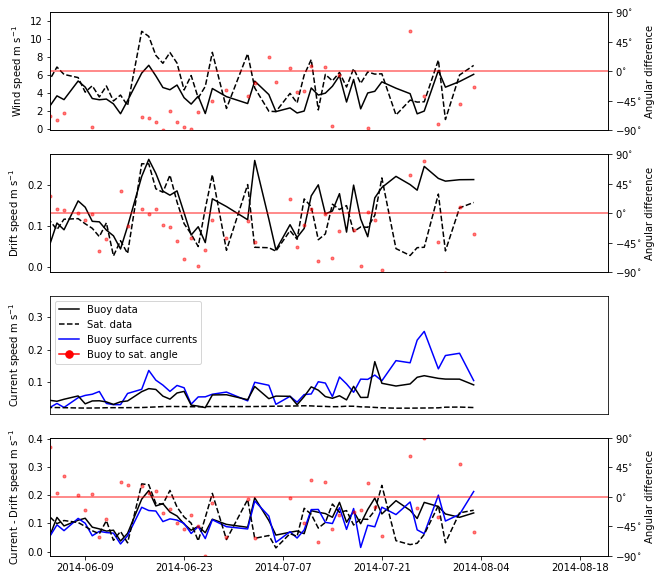

In [27]:
fig_location = '/Users/H/Documents/Tex/Papers/Inverse_paper/Final_figures/'
# plot data - wind, ice, ocn, ocn-ice
# line plot of mag = angular difference
alpha_a = 0.5
f = plt.figure(figsize=[10,10])
ax1 = plt.subplot(4,1,1)
plt.plot_date(date_plot,data_mean_single[np.isfinite(data_use_mask),4],'-k')
plt.plot_date(date_plot,np.hypot(ERA_U[np.isfinite(data_use_mask),0],ERA_U[np.isfinite(data_use_mask),1])
         ,'--k')
plt.xlim([datetime.datetime(2014,6,4),datetime.datetime(2014,8,22)])
plt.ylabel(r'Wind speed m s$^{-1}$')
plt.yticks([0,2,4,6,8,10,12])
ax2 = ax1.twinx()

temp = np.empty(days_use)
for dd in range(days_use):
    temp[dd] = freedrift.ang_between(data_mean_single[dd,2],data_mean_single[dd,3],
                              ERA_U[dd,0],ERA_U[dd,1])
plt.plot_date(date_plot,np.rad2deg(temp[np.isfinite(data_use_mask)]),'.r',alpha = alpha_a)
plt.ylim([-90,90])
plt.yticks([-90,-45,0,45,90],
           [r'$-90^{\circ}$',r'$-45^{\circ}$',r'$0^{\circ}$',r'$45^{\circ}$',r'$90^{\circ}$'])
plt.ylabel(r'Angular difference')
plt.xlim([datetime.datetime(2014,6,4),datetime.datetime(2014,8,22)])
plt.axhline(0.0,color='r',alpha = 0.6)
plt.xticks([])


ax1 = plt.subplot(4,1,2)
plt.plot_date(date_plot,data_mean_5[np.isfinite(data_use_mask),5],'-k')
plt.plot_date(date_plot,np.hypot(DRIFT[np.isfinite(data_use_mask),0],DRIFT[np.isfinite(data_use_mask),1])
         ,'--k')
plt.xlim([datetime.datetime(2014,6,4),datetime.datetime(2014,8,22)])
plt.ylabel(r'Drift speed m s$^{-1}$')
ax2 = ax1.twinx()
plt.xticks([])

temp = np.empty(days_use)
for dd in range(days_use):
    temp[dd] = freedrift.ang_between(data_mean_5[dd,7],data_mean_5[dd,8],
                              DRIFT[dd,0],DRIFT[dd,1])
plt.plot_date(date_plot,np.rad2deg(temp[np.isfinite(data_use_mask)]),'.r',alpha = alpha_a)

# temp = np.empty(days_use)
# for dd in range(days_use):
#     temp[dd] = freedrift.ang_between(data_mean_single[dd,2],data_mean_single[dd,3],
#                               data_mean_5[dd,7],data_mean_5[dd,8])
# plt.plot_date(date_plot,np.rad2deg(temp[np.isfinite(data_use_mask)]),'-b',alpha = alpha_a)
plt.ylim([-90,90])
plt.yticks([-90,-45,0,45,90],
           [r'$-90^{\circ}$',r'$-45^{\circ}$',r'$0^{\circ}$',r'$45^{\circ}$',r'$90^{\circ}$'])
plt.ylabel(r'Angular difference')
plt.xlim([datetime.datetime(2014,6,4),datetime.datetime(2014,8,22)])
plt.axhline(0.0,color='r',alpha = 0.6)
plt.xticks([])

ax1 = plt.subplot(4,1,3)
plt.plot_date(date_plot,data_mean_5[np.isfinite(data_use_mask),6],'-b')
plt.plot_date(date_plot,data_mean_geo[np.isfinite(data_use_mask),5],'-k')
# plt.plot_date(date_plot,np.hypot(
#         data_mean_geo[np.isfinite(data_use_mask),1] + data_mean_5[np.isfinite(data_use_mask),7],
#         data_mean_geo[np.isfinite(data_use_mask),2] + data_mean_5[np.isfinite(data_use_mask),8]),'-k')
# plt.plot_date(date_plot,np.hypot(
#         data_mean_5[np.isfinite(data_use_mask),2] + data_mean_5[np.isfinite(data_use_mask),7],
#         data_mean_5[np.isfinite(data_use_mask),3] + data_mean_5[np.isfinite(data_use_mask),8]),'-b')
plt.plot_date(date_plot,np.hypot(GEO_W[np.isfinite(data_use_mask),0],GEO_W[np.isfinite(data_use_mask),1])
         ,'--k')
plt.xlim([datetime.datetime(2014,6,4),datetime.datetime(2014,8,22)])
# plt.yticks([0,0.1,0.2])
plt.ylabel(r'Current speed m s$^{-1}$')
# ax2 = ax1.twinx()
patch1 = mlines.Line2D([], [], color='k', label='Buoy data')
patch2 = mlines.Line2D([], [], linestyle = 'dashed',color='k', label='Sat. data')
patch3 = mlines.Line2D([], [], color='b', label='Buoy surface currents')
patch4 = mlines.Line2D([], [], color='r', marker='.',markersize=15, label='Buoy to sat. angle')
ax1.legend(handles=[patch1,patch2,patch3,patch4])
plt.xticks([])

# temp = np.empty(days_use)
# for dd in range(days_use):
#     temp[dd] = freedrift.ang_between(data_mean_geo[dd,1] + data_mean_5[dd,7],
#                                      data_mean_geo[dd,2] + data_mean_5[dd,8],
#                               GEO_W[dd,0],GEO_W[dd,1])
# plt.plot_date(date_plot,np.rad2deg(temp[np.isfinite(data_use_mask)]),'.r',alpha = alpha_a)
# plt.ylim([-90,90])
# plt.yticks([-90,-45,0,45,90],
#            [r'$-90^{\circ}$',r'$-45^{\circ}$',r'$0^{\circ}$',r'$45^{\circ}$',r'$90^{\circ}$'])
# plt.ylabel(r'Angular difference')
# plt.xlim([datetime.datetime(2014,6,4),datetime.datetime(2014,8,22)])
# plt.axhline(0.0,color='r',alpha = 0.6)
# plt.xticks([])

ax1 = plt.subplot(4,1,4)
plt.plot_date(date_plot,data_mean_geo[np.isfinite(data_use_mask),3],'-k')
plt.plot_date(date_plot,data_mean_5[np.isfinite(data_use_mask),4],'-b')
plt.plot_date(date_plot,np.hypot(
    GEO_W[np.isfinite(data_use_mask),0]-DRIFT[np.isfinite(data_use_mask),0],
    GEO_W[np.isfinite(data_use_mask),1]-DRIFT[np.isfinite(data_use_mask),1])
         ,'--k')
plt.xlim([datetime.datetime(2014,6,4),datetime.datetime(2014,8,22)])
plt.ylabel(r'Current - Drift speed m s$^{-1}$')
ax2 = ax1.twinx()

temp = np.empty(days_use)
for dd in range(days_use):
    temp[dd] = freedrift.ang_between(data_mean_geo[dd,1],data_mean_geo[dd,2],
                              GEO_W[dd,0]-DRIFT[dd,0],GEO_W[dd,1]-DRIFT[dd,1])
plt.plot_date(date_plot,np.rad2deg(temp[np.isfinite(data_use_mask)]),'.r',alpha = alpha_a)
plt.ylim([-90,90])
plt.yticks([-90,-45,0,45,90],
           [r'$-90^{\circ}$',r'$-45^{\circ}$',r'$0^{\circ}$',r'$45^{\circ}$',r'$90^{\circ}$'])
plt.ylabel(r'Angular difference')
plt.xlim([datetime.datetime(2014,6,4),datetime.datetime(2014,8,22)])
plt.axhline(0.0,color='r',alpha = 0.6)

plt.show()
f.savefig(fig_location+'buoy_03_input_data.pdf',format='pdf',bbox_inches='tight')

In [3]:
days_use - first_day - nbals

NameError: name 'days_use' is not defined

In [89]:
day_start,first_day, days_use,inv_list_d
# inv_list_d[30:50,:]

(20, 8, 26, array([[ 5,  8,  9, 10, 11, 12],
        [ 5,  9, 10, 11, 12, 13],
        [ 5, 10, 11, 12, 13, 14],
        [ 5, 11, 12, 13, 14, 15],
        [ 5, 12, 13, 14, 15, 16],
        [ 5, 13, 14, 15, 16, 17],
        [ 5, 14, 15, 16, 17, 18],
        [ 5, 15, 16, 17, 18, 19],
        [ 5, 16, 17, 18, 19, 20],
        [ 5, 17, 18, 19, 20, 21],
        [ 5, 18, 19, 20, 21, 22],
        [ 5, 19, 20, 21, 22, 23],
        [ 5, 20, 21, 22, 23, 24]]))

In [90]:
inv_list_d[-1,1]
data_ranges[inv_list_d[-1,1],0]
d150_tstart[data_ranges[inv_list_d[-1,5],0]]

datetime.datetime(2014, 7, 16, 0, 2, 2, 2)

In [29]:
for dd in range(0,list_d-nbals):
    day_start = bal_all[dd]
#     print(day_start,bal_all[dd:dd+nbals+1]-day_start)

In [91]:
na_location = '/Users/H/INVERSE/Sylvia_data/NA_setup/NA_geo_O-A/'
# na_location = '/Users/H/INVERSE/Sylvia_data/NA_setup/NA_geo/'
# na_location = '/Users/H/INVERSE/Sylvia_data/NA_setup/NA_geo_thAC/'
# for dd in range(0,list_d-nbals):
for dd in range(0,invs_to_do):
# for dd in range(0,5):
#     day_start = bal_all[dd]
    day_start = inv_list_d[dd,1]

# will now filter the data before processing ot get the exact number of records to do
    # load up the data
    nbals_use = inv_list_d[dd,0]
    data_in = np.ndarray([nbals_use*17+13],dtype='float32')
#     print('Inverting day ',day_start,', no ',dd,' of ',list_d)
    print('Inverting day ',day_start,', no ',dd + 1,' of ',invs_to_do,' nbals = ',nbals_use)
    
    Na2_scale = 0.015**2
    beta_a = np.ndarray([nbals_use])
    beta_i = np.ndarray([nbals_use])
    beta_g = np.ndarray([nbals_use])
    beta_fb= np.ndarray([nbals_use])
    # for j in range(nbals_use):
    #     i = bal_p[j]
    #     beta_a[j] = 0.0/Bbeta_a # 1.0 #     data_mean_big[day_start+day+i,2,d_w]**-2*Na2_scale**3
    #     beta_i[j] = 0.0/Bbeta_i # 1.0 #  data_mean_single[day_start+day+i,4]**-2*Na2_scale
    #     beta_fb[j]= 1.0/Bbeta_fb# 1.0 #  data_mean_single[day_start+day+i,4]**-4
    for j in range(nbals_use):
        i = bal_p[j]
        beta_a[j] =  1.0 #     data_mean_big[day_start+day+i,2,d_w]**-2*Na2_scale**3
        beta_i[j] =  1.0 #  data_mean_single[day_start+day+i,4]**-2*Na2_scale
        beta_g[j] =  0.0 #  data_mean_single[day_start+day+i,4]**-2*Na2_scale
        beta_fb[j]=  1.0 #  data
    r = 0;
    data_in[0] = nbals_use;
#     inv_list_d[dd,0]=nbals_use
    for j in range(nbals_use):
#         i = bal_p[j]
#         i = bal_all[dd+j]-day_start
#         inv_list_d[dd,1+j] = day_start + i
        i = inv_list_d[dd,j+1] - day_start
        # wind data
        data_in[1+0*nbals_use+j] = data_mean_single[day_start+i,2] # uwind
        data_in[1+1*nbals_use+j] = data_mean_single[day_start+i,3] # vwind
        data_in[1+2*nbals_use+j] = data_mean_single[day_start+i,4] # mag
        data_in[1+3*nbals_use+j] = data_std_single[ day_start+i,7] # sig
        # i_o data
        data_in[1+4*nbals_use+j] = data_mean_5[day_start+i,2] # uice
        data_in[1+5*nbals_use+j] = data_mean_5[day_start+i,3] # vice
        data_in[1+6*nbals_use+j] = data_mean_5[day_start+i,4] # mag
        data_in[1+7*nbals_use+j] = data_std_5[ day_start+i,3] # sig
        # i_o data geo
        data_in[1+8*nbals_use+j] = data_mean_geo[day_start+i,1] # uice
        data_in[1+9*nbals_use+j] = data_mean_geo[day_start+i,2] # vice
        data_in[1+10*nbals_use+j] = data_mean_geo[day_start+i,3] # mag
        data_in[1+11*nbals_use+j] = data_std_geo[ day_start+i,3] # sig
    #     data_in[1+7*nbals_use+i] = data_mean_big[ day_start+i,5,d_w] # sig
       # scale data
        data_in[1+12*nbals_use+j] = beta_a[j] ;r+=nbals_use # beta scalings - see above
        data_in[1+13*nbals_use+j] = beta_i[j] ;r+=nbals_use
        data_in[1+14*nbals_use+j] = beta_g[j] ;r+=nbals_use
        data_in[1+15*nbals_use+j] = beta_fb[j];r+=nbals_use
        data_in[1+16*nbals_use+j] = (data_mean_single[day_start+i,7]*
                                 data_mean_single[day_start+i,8]) # hifc   
    r = 1 + 17 * nbals_use
    # other data/constants
    data_in[r] = rhoa ;r+=1
    data_in[r] = rhoi ;r+=1
    data_in[r] = rhoo ;r+=1
#     data_in[r] = thAC ;r+=1
    # special for range
    data_in[r] = n2a_min;r+=1
    data_in[r] = n2a_max;r+=1
    data_in[r] = rop_min;r+=1
    data_in[r] = rop_max;r+=1
    data_in[r] = thO_min;r+=1
    data_in[r] = thO_max;r+=1
    data_in[r] = thAO_min;r+=1
    data_in[r] = thAO_max;r+=1
    f = open(na_location+'/freedrift_IC','wb')
    data_in.tofile(f,sep=' ')
    f.close()
    
    #!!!! RUN THE NA !!!!
    if (nbals_use>2):
#         ! nohup NA_setup/NA_geo/bin/freedrift_na 
#         ! nohup NA_setup/NA_geo/nad2asc na.nad na.asc
        ! nohup NA_setup/NA_geo_O-A/bin/freedrift_na 
        ! nohup NA_setup/NA_geo_O-A/nad2asc na.nad na.asc
#     ! nohup NA_setup/NA_geo_thAC/bin/freedrift_na
#     ! NA_setup/NA_run_i_o_w_a/bin/freedrift_na
#     ! NA_setup/NA_run_i_o_w_a/nad2asc na.nad na.asc
#     ! NA_setup/NA_run_i_o_w_a_thAC/bin/freedrift_na
#     ! NA_setup/NA_run_i_o_w_a_thAC/nad2asc na.nad na.asc
#         ! nohup NA_setup/NA_geo/bin/freedrift_na 
#         ! NA_setup/NA_geo/nad2asc na.nad na.asc
#     ! nohup NA_setup/NA_geo_thAC/bin/freedrift_na
#     ! NA_setup/NA_geo_thAC/nad2asc na.nad na.asc
    # # read output
        data_NA = ascii.read(location+'/na.asc',guess=False,header_start=7,data_start=14,
                         names=['number','Na','Ro','thO','thA-O','misfit'])
    #     data_NA = ascii.read(location+'/na.asc',guess=False,header_start=13,data_start=13,
    #                      names=['number','Na','Ro','thO','misfit'])

        misfit_filter = 1e7
        misfit_min = data_NA['misfit'][0]
        misfit_ratio = 0.25
        misfit_max = 0.0
        misfit_min_no = 0
        for i in data_NA['number'][0:-1]:
            if data_NA['misfit'][i] < misfit_min:
                misfit_min = data_NA['misfit'][i]
                misfit_min_no = i
            if (data_NA['misfit'][i] > misfit_max and data_NA['misfit'][i] < misfit_filter):
                misfit_max = data_NA['misfit'][i]
        misfit_range = misfit_max/misfit_min

        misfit_cut = misfit_min**(1.0 - misfit_ratio)*misfit_max**misfit_ratio
        # number_cut = int(3*data_NA['number'][-1]/4)
        number_cut = it1
        data_NA_cut = np.empty([6,data_NA['number'][-1]])
        #
        i_cut = -1
        for i in data_NA['number'][number_cut:-1]:
            if data_NA['misfit'][i] < misfit_cut:
                i_cut += 1
                data_NA_cut[0,i_cut] = data_NA['number'][i]
                data_NA_cut[1,i_cut] = data_NA['Na'][i]
                data_NA_cut[2,i_cut] = data_NA['Ro'][i]
                data_NA_cut[3,i_cut] = data_NA['thO'][i]
                data_NA_cut[4,i_cut] = data_NA['thA-O'][i]
    #             data_NA_cut[4,i_cut] = 0.0
                data_NA_cut[5,i_cut] = data_NA['misfit'][i]

        # save the NA results
        inv_data_d[dd,0] = data_NA['misfit'][misfit_min_no]
        inv_data_d[dd,1] = misfit_range
        inv_data_d[dd,2] = misfit_cut
        inv_data_d[dd,3] = data_NA['Na'][misfit_min_no]
        inv_data_d[dd,4] = data_NA['Ro'][misfit_min_no]
        inv_data_d[dd,5] = data_NA['thO'][misfit_min_no]
        inv_data_d[dd,6] = data_NA['thA-O'][misfit_min_no]
    #     inv_data_d[day_start-first_day,6] = 0.0
        inv_data_d[dd,7:10]  = np.percentile(data_NA_cut[1,0:i_cut],[5,50,95])
        inv_data_d[dd,10:13] = np.percentile(data_NA_cut[2,0:i_cut],[5,50,95])
        inv_data_d[dd,13:16] = np.percentile(data_NA_cut[3,0:i_cut],[5,50,95])
        inv_data_d[dd,16:19] = np.percentile(data_NA_cut[4,0:i_cut],[5,50,95])
    #     inv_data_d[day_start-first_day,16:19] = [0.0,0.0,0.0]

        # copy the ouput for NA_bayes
    #     ! cp na.nad ensemble.nad
    #     # run the NA_bayes
    #     # THIS IS THE SLOW BIT
    #     ! NA_setup/NA_Bayes/bin/freedrift_nab
        # read the ouput
        file = location+'/nab.samples'
        data_bayes=np.genfromtxt(file,skip_header=3)
        # means and deviations
        inv_data_d[dd,20]= np.mean(data_bayes[:,0])
        inv_data_d[dd,21]= np.mean(data_bayes[:,1])
        inv_data_d[dd,22]= np.mean(data_bayes[:,2])
        inv_data_d[dd,23]= np.mean(data_bayes[:,3])
    #     inv_data_d[day_start-first_day,23] = 0.0
        inv_data_d[dd,24]= np.std(data_bayes[:,0])
        inv_data_d[dd,25]= np.std(data_bayes[:,1])
        inv_data_d[dd,26]= np.std(data_bayes[:,2])
        inv_data_d[dd,27]= np.std(data_bayes[:,3])
    #     inv_data_d[day_start-first_day,27] = 0.0
        inv_data_d[dd,28:31] = np.percentile(data_bayes[:,0],[25,50,75])
        inv_data_d[dd,31:34] = np.percentile(data_bayes[:,1],[25,50,75])
        inv_data_d[dd,34:37] = np.percentile(data_bayes[:,2],[25,50,75])
        inv_data_d[dd,37:40] = np.percentile(data_bayes[:,3],[25,50,75])
    #     inv_data_d[day_start-first_day,37:40] = [0.0,0.0,0.0]
    else:
        inv_data_d[dd,:] = np.nan

Inverting day  8 , no  1  of  13  nbals =  5
appending output to nohup.out
appending output to nohup.out
Inverting day  9 , no  2  of  13  nbals =  5
appending output to nohup.out
appending output to nohup.out
Inverting day  10 , no  3  of  13  nbals =  5
appending output to nohup.out
appending output to nohup.out
Inverting day  11 , no  4  of  13  nbals =  5
appending output to nohup.out
appending output to nohup.out
Inverting day  12 , no  5  of  13  nbals =  5
appending output to nohup.out
appending output to nohup.out
Inverting day  13 , no  6  of  13  nbals =  5
appending output to nohup.out
appending output to nohup.out
Inverting day  14 , no  7  of  13  nbals =  5
appending output to nohup.out
appending output to nohup.out
Inverting day  15 , no  8  of  13  nbals =  5
appending output to nohup.out
appending output to nohup.out
Inverting day  16 , no  9  of  13  nbals =  5
appending output to nohup.out
appending output to nohup.out
Inverting day  17 , no  10  of  13  nbals =  5
a

In [92]:
#  convert inv list to be careful with the strides BE CAREFUL DON"T DO IT TWICE
inv_list_d_save =  np.zeros(np.shape(inv_list_d),dtype=int)
inv_list_d_save[:,0] = inv_list_d[:,0]
for i in range(invs_to_do): inv_list_d_save[i,1:inv_list_d[i,0]+1] = inv_list_d[i,1:inv_list_d[i,0]+1]*day_strd

save_file = '/Inverted_groups_03/inverted_group_18_08_06_na_only_d5_geo_O-A_10d.npz'
np.savez(location+save_file,inv_list_d=inv_list_d,inv_data_d=inv_data_d )


In [95]:
na_location = '/Users/H/INVERSE/Sylvia_data/NA_setup/NA_i_o_O-A/'
# na_location = '/Users/H/INVERSE/Sylvia_data/NA_setup/NA_run_i_o_w_a/'
# na_location = '/Users/H/INVERSE/Sylvia_data/NA_setup/NA_run_i_o_w_a_thAC/'
# na_location = '/Users/H/INVERSE/Sylvia_data/NA_setup/NA_geo/'
# na_location = '/Users/H/INVERSE/Sylvia_data/NA_setup/NA_geo_thAC/'
# for dd in range(0,list_d-nbals):
for dd in range(0,invs_to_do):
# for dd in range(0,2):
#     day_start = bal_all[dd]
    day_start = inv_list_d[dd,1]
    nbals_use = inv_list_d[dd,0]
#     print('Inverting day ',day_start,', no ',dd,' of ',list_d)
    print('Inverting day ',day_start,', no ',dd + 1,' of ',invs_to_do,' nbals = ',nbals_use)

# will now filter the data before processing ot get the exact number of records to do
    # load up the data
    data_in = np.ndarray([nbals_use*12+13],dtype='float32')
    
    Na2_scale = 0.015**2
    beta_a = np.ndarray([nbals_use])
    beta_i = np.ndarray([nbals_use])
    beta_w = np.ndarray([nbals_use])
    beta_fb= np.ndarray([nbals_use])
    # for j in range(nbals_use):
    #     i = bal_p[j]
    #     beta_a[j] = 0.0/Bbeta_a # 1.0 #     data_mean_big[day_start+day+i,2,d_w]**-2*Na2_scale**3
    #     beta_i[j] = 0.0/Bbeta_i # 1.0 #  data_mean_single[day_start+day+i,4]**-2*Na2_scale
    #     beta_fb[j]= 1.0/Bbeta_fb# 1.0 #  data_mean_single[day_start+day+i,4]**-4
    for j in range(nbals_use):
        i = bal_p[j]
        beta_a[j] =  1.0 #     data_mean_big[day_start+day+i,2,d_w]**-2*Na2_scale**3
        beta_i[j] =  1.0 #  data_mean_single[day_start+day+i,4]**-2*Na2_scale
        beta_fb[j]=  1.0 #  data
    r = 0;
    data_in[0] = nbals_use;
#     inv_list_d[dd,0]=nbals_use
    for j in range(nbals_use):
#         i = bal_p[j]
#         i = bal_all[dd+j]-day_start
#         inv_list_d[dd,1+j] = day_start + i
        i = inv_list_d[dd,j+1] - day_start
        # wind data
        data_in[1+0*nbals_use+j] = data_mean_single[day_start+i,2] # uwind
        data_in[1+1*nbals_use+j] = data_mean_single[day_start+i,3] # vwind
        data_in[1+2*nbals_use+j] = data_mean_single[day_start+i,4] # mag
        data_in[1+3*nbals_use+j] = data_std_single[ day_start+i,7] # sig
        # i_o data
#         data_in[1+4*nbals_use+j] = data_mean_5[day_start+i,2] # uice
#         data_in[1+5*nbals_use+j] = data_mean_5[day_start+i,3] # vice
#         data_in[1+6*nbals_use+j] = data_mean_5[day_start+i,4] # mag
#         data_in[1+7*nbals_use+j] = data_std_5[ day_start+i,3] # sig

#         data_in[1+0*nbals_use+j] = ERA_U[day_start+i,0] # uwind
#         data_in[1+1*nbals_use+j] = ERA_U[day_start+i,1] # vwind
#         data_in[1+2*nbals_use+j] = ERA_U[day_start+i,2] # mag
#         data_in[1+3*nbals_use+j] = ERA_U[day_start+i,4] # sig
        data_in[1+0*nbals_use+j] = ERA_U_mean[day_start+i,0] # uwind
        data_in[1+1*nbals_use+j] = ERA_U_mean[day_start+i,1] # vwind
        data_in[1+2*nbals_use+j] = ERA_U_mean[day_start+i,2] # mag
        data_in[1+3*nbals_use+j] = ERA_U_mean[day_start+i,3] # sig
        # i_o data geo
        data_in[1+4*nbals_use+j] = data_mean_geo[day_start+i,1] # uice
        data_in[1+5*nbals_use+j] = data_mean_geo[day_start+i,2] # vice
        data_in[1+6*nbals_use+j] = data_mean_geo[day_start+i,3] # mag
        data_in[1+7*nbals_use+j] = data_std_geo[ day_start+i,3] # sig
        
#         data_in[1+4*nbals_use+j] = GEO_W[day_start+i,0] - DRIFT[day_start+i,0] # uwind
#         data_in[1+5*nbals_use+j] = GEO_W[day_start+i,1] - DRIFT[day_start+i,1] # vwind
#         data_in[1+6*nbals_use+j] = np.hypot(data_in[1+0*nbals_use+j] , data_in[1+1*nbals_use+j]) # mag
#         data_in[1+7*nbals_use+j] = np.hypot(GEO_W[day_start+i,4] , DRIFT[day_start+i,4]) # sig
    #     data_in[1+7*nbals_use+i] = data_mean_big[ day_start+i,5,d_w] # sig
        data_in[1+4*nbals_use+j] = SATOI_mean[day_start+i,0] 
        data_in[1+5*nbals_use+j] = SATOI_mean[day_start+i,1]
        data_in[1+6*nbals_use+j] = SATOI_mean[day_start+i,2]
        data_in[1+7*nbals_use+j] = SATOI_mean[day_start+i,3]

    #     data_in[1+7*nbals_use+i] = data_mean_big[ day_start+i,5,d_w] # sig
       # scale data
        data_in[1+8*nbals_use+j] = beta_a[j] ;r+=nbals_use # beta scalings - see above
        data_in[1+9*nbals_use+j] = beta_i[j] ;r+=nbals_use
        data_in[1+10*nbals_use+j] = beta_fb[j];r+=nbals_use
        data_in[1+11*nbals_use+j] = (data_mean_single[day_start+i,7]*
                                 data_mean_single[day_start+i,8]) # hifc   
    r = 1 + 12 * nbals_use
    # other data/constants
    data_in[r] = rhoa ;r+=1
    data_in[r] = rhoi ;r+=1
    data_in[r] = rhoo ;r+=1
#     data_in[r] = thAC ;r+=1
    # special for range
    data_in[r] = n2a_min;r+=1
    data_in[r] = n2a_max;r+=1
    data_in[r] = rop_min;r+=1
    data_in[r] = rop_max;r+=1
    data_in[r] = thO_min;r+=1
    data_in[r] = thO_max;r+=1
    data_in[r] = thAO_min;r+=1
    data_in[r] = thAO_max;r+=1
    f = open(na_location+'/freedrift_IC','wb')
    data_in.tofile(f,sep=' ')
    f.close()
    
    #!!!! RUN THE NA !!!!
    if (nbals_use>2):
    #!!!! RUN THE NA !!!!
#         ! nohup NA_setup/NA_run_i_o_w_a/bin/freedrift_na
#         ! nohup NA_setup/NA_run_i_o_w_a/nad2asc na.nad na.asc
        ! nohup NA_setup/NA_i_o_O-A/bin/freedrift_na
        ! nohup NA_setup/NA_i_o_O-A/nad2asc na.nad na.asc
#         ! nohup NA_setup/NA_run_i_o_w_a/bin/freedrift_na
#         ! nohup NA_setup/NA_run_i_o_w_a/nad2asc na.nad na.asc
#     ! NA_setup/NA_run_i_o_w_a_thAC/bin/freedrift_na
#     ! NA_setup/NA_run_i_o_w_a_thAC/nad2asc na.nad na.asc
#     ! NA_setup/NA_geo/bin/freedrift_na
#     ! NA_setup/NA_geo/nad2asc na.nad na.asc
    # # read output
        data_NA = ascii.read(location+'/na.asc',guess=False,header_start=7,data_start=14,
                         names=['number','Na','Ro','thO','thA-O','misfit'])
    #     data_NA = ascii.read(location+'/na.asc',guess=False,header_start=13,data_start=13,
    #                      names=['number','Na','Ro','thO','misfit'])

        misfit_filter = 1e7
        misfit_min = data_NA['misfit'][0]
        misfit_ratio = 0.25
        misfit_max = 0.0
        misfit_min_no = 0
        for i in data_NA['number'][0:-1]:
            if data_NA['misfit'][i] < misfit_min:
                misfit_min = data_NA['misfit'][i]
                misfit_min_no = i
            if (data_NA['misfit'][i] > misfit_max and data_NA['misfit'][i] < misfit_filter):
                misfit_max = data_NA['misfit'][i]
        misfit_range = misfit_max/misfit_min

        misfit_cut = misfit_min**(1.0 - misfit_ratio)*misfit_max**misfit_ratio
        # number_cut = int(3*data_NA['number'][-1]/4)
        number_cut = it1
        data_NA_cut = np.empty([6,data_NA['number'][-1]])
        #
        i_cut = -1
        for i in data_NA['number'][number_cut:-1]:
            if data_NA['misfit'][i] < misfit_cut:
                i_cut += 1
                data_NA_cut[0,i_cut] = data_NA['number'][i]
                data_NA_cut[1,i_cut] = data_NA['Na'][i]
                data_NA_cut[2,i_cut] = data_NA['Ro'][i]
                data_NA_cut[3,i_cut] = data_NA['thO'][i]
                data_NA_cut[4,i_cut] = data_NA['thA-O'][i]
    #             data_NA_cut[4,i_cut] = 0.0
                data_NA_cut[5,i_cut] = data_NA['misfit'][i]

        # save the NA results
        inv_data_d[dd,0] = data_NA['misfit'][misfit_min_no]
        inv_data_d[dd,1] = misfit_range
        inv_data_d[dd,2] = misfit_cut
        inv_data_d[dd,3] = data_NA['Na'][misfit_min_no]
        inv_data_d[dd,4] = data_NA['Ro'][misfit_min_no]
        inv_data_d[dd,5] = data_NA['thO'][misfit_min_no]
        inv_data_d[dd,6] = data_NA['thA-O'][misfit_min_no]
    #     inv_data_d[dd,6] = 0.0
        inv_data_d[dd,7:10]  = np.percentile(data_NA_cut[1,0:i_cut],[5,50,95])
        inv_data_d[dd,10:13] = np.percentile(data_NA_cut[2,0:i_cut],[5,50,95])
        inv_data_d[dd,13:16] = np.percentile(data_NA_cut[3,0:i_cut],[5,50,95])
        inv_data_d[dd,16:19] = np.percentile(data_NA_cut[4,0:i_cut],[5,50,95])
    #     inv_data_d[dd,16:19] = [0.0,0.0,0.0]

        # copy the ouput for NA_bayes
    #     ! cp na.nad ensemble.nad
    #     # run the NA_bayes
    #     # THIS IS THE SLOW BIT
    #     ! NA_setup/NA_Bayes/bin/freedrift_nab
        # read the ouput
        file = location+'/nab.samples'
        data_bayes=np.genfromtxt(file,skip_header=3)
        # means and deviations
        inv_data_d[dd,20]= np.mean(data_bayes[:,0])
        inv_data_d[dd,21]= np.mean(data_bayes[:,1])
        inv_data_d[dd,22]= np.mean(data_bayes[:,2])
        inv_data_d[dd,23]= np.mean(data_bayes[:,3])
    #     inv_data_d[dd,23] = 0.0
        inv_data_d[dd,24]= np.std(data_bayes[:,0])
        inv_data_d[dd,25]= np.std(data_bayes[:,1])
        inv_data_d[dd,26]= np.std(data_bayes[:,2])
        inv_data_d[dd,27]= np.std(data_bayes[:,3])
    #     inv_data_d[dd,27] = 0.0
        inv_data_d[dd,28:31] = np.percentile(data_bayes[:,0],[25,50,75])
        inv_data_d[dd,31:34] = np.percentile(data_bayes[:,1],[25,50,75])
        inv_data_d[dd,34:37] = np.percentile(data_bayes[:,2],[25,50,75])
        inv_data_d[dd,37:40] = np.percentile(data_bayes[:,3],[25,50,75])
    #     inv_data_d[dd,37:40] = [0.0,0.0,0.0]
    else:
        inv_data_d[dd,:] = np.nan

Inverting day  8 , no  1  of  13  nbals =  5
appending output to nohup.out
appending output to nohup.out
Inverting day  9 , no  2  of  13  nbals =  5
appending output to nohup.out
appending output to nohup.out
Inverting day  10 , no  3  of  13  nbals =  5
appending output to nohup.out
appending output to nohup.out
Inverting day  11 , no  4  of  13  nbals =  5
appending output to nohup.out
appending output to nohup.out
Inverting day  12 , no  5  of  13  nbals =  5
appending output to nohup.out
appending output to nohup.out
Inverting day  13 , no  6  of  13  nbals =  5
appending output to nohup.out
appending output to nohup.out
Inverting day  14 , no  7  of  13  nbals =  5
appending output to nohup.out
appending output to nohup.out
Inverting day  15 , no  8  of  13  nbals =  5
appending output to nohup.out
appending output to nohup.out
Inverting day  16 , no  9  of  13  nbals =  5
appending output to nohup.out
appending output to nohup.out
Inverting day  17 , no  10  of  13  nbals =  5
a

In [96]:
#  convert inv list to be careful with the strides BE CAREFUL DON"T DO IT TWICE
inv_list_d_save =  np.zeros(np.shape(inv_list_d),dtype=int)
inv_list_d_save[:,0] = inv_list_d[:,0]
for i in range(invs_to_do): inv_list_d_save[i,1:inv_list_d[i,0]+1] = inv_list_d[i,1:inv_list_d[i,0]+1]*day_strd

save_file = '/Inverted_groups_03/inverted_group_18_08_06_na_only_geo_geo_10d_SAT.npz'
np.savez(location+save_file,inv_list_d=inv_list_d,inv_data_d=inv_data_d )


In [43]:
# constants and ranges
nansen_use = 0.022**2
rossby_use = 500
n2a_min = nansen_use*1e-2
n2a_max = nansen_use*1e1
rop_min = rossby_use*1e-2
rop_max = rossby_use*3e0
print(n2a_min, np.sqrt(nansen_use), nansen_use, n2a_max)
print(rop_min, rossby_use, rop_max)
# general inv parameters
rhoa = 1.25 
rhoi = 917.0 
rhoo = 1026.0 

Ca_min = 1.0e-6
Ca_max = 2.0e-3
Co_min = 1.0e-3
Co_max = 6.0e-2

# invert for thO and thA-thO
# these replace for thO
thO_min = np.deg2rad(-179)
thO_max = np.deg2rad( 180)
# these replace for thA-thO
thAO_min = np.deg2rad(-179)
thAO_max = np.deg2rad( 180)

# constant thetaA if needed
thAC = np.rad2deg(0)


4.839999999999999e-06 0.022 0.00048399999999999995 0.00484
5.0 500 1500.0


In [79]:
inv_data_d[:,0]

array([  9.16077197e-002,   9.22910869e-002,   9.15587991e-002,
         9.15587991e-002,   9.15558338e-002,   9.15587991e-002,
         9.14006606e-002,   2.31355124e-314,   9.15587991e-002,
         9.13597345e-002,   2.29951579e-314,   9.15587991e-002,
         9.15587991e-002,   2.29446019e-314,   9.15587991e-002,
         2.29951579e-314,   2.29951579e-314,   2.26520053e-314,
         2.30225237e-314,   2.28304371e-314,   9.15587991e-002,
         9.15587991e-002,   2.30225237e-314,   9.15587991e-002,
         9.13711265e-002,   2.62490252e-314,   2.28304365e-314,
         2.24040041e-314,   2.22649276e-314,   2.29951579e-314,
         9.15587991e-002,   9.15587991e-002,   9.22910869e-002,
         9.18823704e-002,   2.29446019e-314,   9.15587991e-002,
         9.18268114e-002,   9.15587991e-002,   9.14006606e-002,
         9.15587991e-002,   9.18262973e-002,   9.15587991e-002,
         9.15587991e-002,   2.28304373e-314,   9.15587991e-002,
         9.15587991e-002,   9.15587991e-

In [38]:
! NA_setup/NA_run_i_o_w_a/bin/freedrift_na
# ! pwd
# # ! bin/freedrift_na
! NA_setup/NA_run_i_o_w_a/nad2asc na.nad na.asc
# # ! cd ../..
# # read output
data_NA = ascii.read(location+'/na.asc',guess=False,header_start=7,data_start=14,
                     names=['number','Na','Ro','thO','thA-O','misfit'])

##### filter misfits
misfit_filter = 1e5
misfit_ratio = 0.2
misfit_min = data_NA['misfit'][0]
misfit_max = 0.0
misfit_min_no = 0
for i in data_NA['number'][0:-1]:
    if data_NA['misfit'][i] < misfit_min:
        misfit_min = data_NA['misfit'][i]
        misfit_min_no = i
    if (data_NA['misfit'][i] > misfit_max and data_NA['misfit'][i] < misfit_filter):
        misfit_max = data_NA['misfit'][i]
misfit_range = misfit_max/misfit_min
# misfit_cut = misfit_min * (1.0 + misfit_range *  1e-3) 
misfit_cut = misfit_min**(1.0 - misfit_ratio)*misfit_max**misfit_ratio
# number_cut = int(3*data_NA['number'][-1]/4)
number_cut = 0
data_NA_cut = np.empty([6,data_NA['number'][-1]])
#
i_cut = -1
for i in data_NA['number'][number_cut:-1]:
    if data_NA['misfit'][i] < misfit_cut:
        i_cut += 1
        data_NA_cut[0,i_cut] = data_NA['number'][i]
        data_NA_cut[1,i_cut] = data_NA['Na'][i]
        data_NA_cut[2,i_cut] = data_NA['Ro'][i]
        data_NA_cut[3,i_cut] = data_NA['thO'][i]
        data_NA_cut[4,i_cut] = data_NA['thA-O'][i]
        data_NA_cut[5,i_cut] = data_NA['misfit'][i]
print(i_cut, misfit_min_no,np.mean(data_NA_cut[5,0:i_cut+1]))


  User routines output

  Opening freedrift files...

 Number of balances this time  =    10.0000000              10

  Successfuly read  freedrift files...


  Imposed Parameter space

  nd = 4, Ca, thetaA, Co, thetaO

  Adjusted Parameter space

  nd = 4, Na, Ro,  thetaA, thetaO

  Adjusted Parameter space 2

  nd = 4, Na2, Ro_p,  thetaO, thetaA - thetaOO

  Now invert           10  problems with same parameters
  Problem            1
  Wind_mag =    4.17066669    
  I_O_mag  =    7.96025768E-02
  Problem            2
  Wind_mag =    4.14349985    
  I_O_mag  =    7.53976926E-02
  Problem            3
  Wind_mag =    2.37162495    
  I_O_mag  =    5.84843792E-02
  Problem            4
  Wind_mag =    6.80120850    
  I_O_mag  =   0.137976229    
  Problem            5
  Wind_mag =    6.74945831    
  I_O_mag  =   0.153664306    
  Problem            6
  Wind_mag =    6.15987492    
  I_O_mag  =   0.108580582    
  Problem            7
  Wind_mag =    5.90850019    
  I_O_mag  =   0.

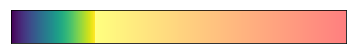

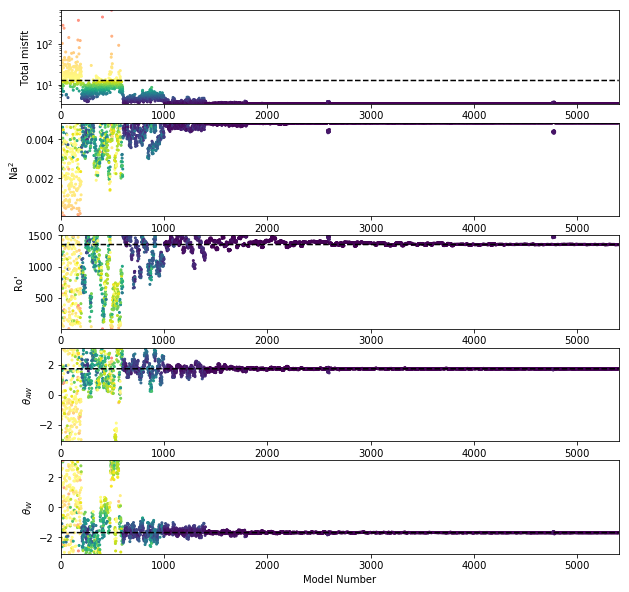

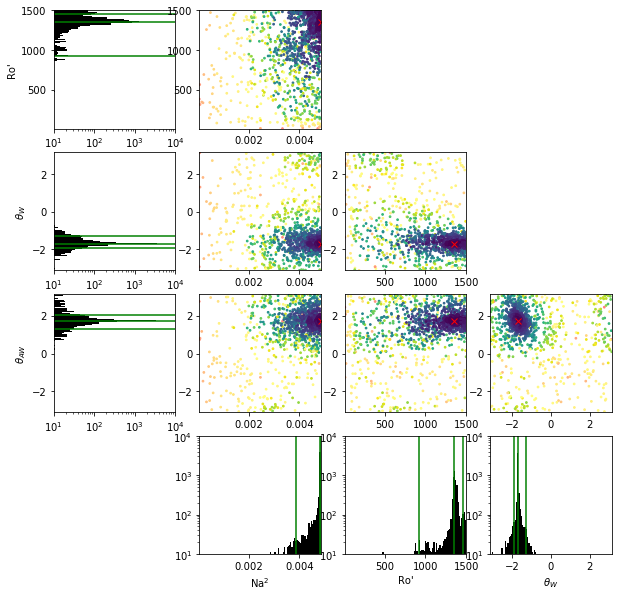

In [45]:
fig_location = '/Users/H/Documents/Tex/Reports/18-06-12/'
big_c = np.int(128*(np.log(misfit_max) - np.log([misfit_cut]))/(np.log(misfit_cut) - np.log([misfit_min])))
colors1 = plt.cm.viridis(np.linspace(0., 1, 128))
# colors1 = plt.cm.YlGnBu_r(np.linspace(0., 1, 128))
colors2 = plt.cm.autumn_r(np.linspace(0, 1, big_c))
# colors = np.vstack((colors1, colors2))
colors = np.vstack((colors1,1-(1-colors2)*0.5))
mymap = mcolors.LinearSegmentedColormap.from_list('my_colormap', colors)
plt.imshow([colors], extent=[0, 10, 0, 1])
plt.xticks([])
plt.yticks([])
plt.show()

# plot misfit
# cmin = 1e-10
# cmax = 1e2
plt.figure(figsize=[10,10])
plt.subplot(5,1,1)
cmin = misfit_min
# cmin = 1e-4
cmax = misfit_max
plt.scatter(data_NA['number'],data_NA['misfit'],c=np.log(data_NA['misfit']),s=4,cmap=mymap)
plt.plot(data_NA['number'],[misfit_cut for j in range(data_NA['number'][-1])],'--k')
plt.xlim([0,data_NA['number'][-1]])
plt.yscale('log')
plt.ylim([cmin,np.max(data_NA['misfit'])])
plt.ylim([cmin,cmax])
plt.clim(np.log([cmin,cmax]))
plt.ylabel('Total misfit')

plt.subplot(5,1,2)
plt.scatter(data_NA['number'],data_NA['Na'],c=np.log(data_NA['misfit']),s=4,cmap=mymap)
plt.plot(data_NA['number'],[data_NA['Na'][misfit_min_no] for j in range(data_NA['number'][-1])],'--k')
plt.xlim([0,data_NA['number'][-1]])
plt.ylim([np.min(data_NA['Na']),np.max(data_NA['Na'])])
plt.clim(np.log([cmin,cmax]))
plt.ylabel(r'Na$^2$')
# plt.savefig('misfit_all_100%.pdf')
plt.subplot(5,1,3)
plt.scatter(data_NA['number'],data_NA['Ro'],c=np.log(data_NA['misfit']),s=4,cmap=mymap)
plt.plot(data_NA['number'],[data_NA['Ro'][misfit_min_no] for j in range(data_NA['number'][-1])],'--k')
plt.xlim([0,data_NA['number'][-1]])
plt.ylim([np.min(data_NA['Ro']),np.max(data_NA['Ro'])])
plt.clim(np.log([cmin,cmax]))
plt.ylabel('Ro\'')
plt.subplot(5,1,4)
plt.scatter(data_NA['number'],data_NA['thA-O'],c=np.log(data_NA['misfit']),s=4,cmap=mymap)
plt.plot(data_NA['number'],[data_NA['thA-O'][misfit_min_no] for j in range(data_NA['number'][-1])],'--k')
plt.xlim([0,data_NA['number'][-1]])
plt.ylim([np.min(data_NA['thA-O']),np.max(data_NA['thA-O'])])
plt.clim(np.log([cmin,cmax]))
plt.ylabel(r'$\theta_{AW}$')
plt.subplot(5,1,5)
plt.scatter(data_NA['number'],data_NA['thO'],c=np.log(data_NA['misfit']),s=4,cmap=mymap)
plt.plot(data_NA['number'],[data_NA['thO'][misfit_min_no] for j in range(data_NA['number'][-1])],'--k')
plt.xlim([0,data_NA['number'][-1]])
plt.ylim([np.min(data_NA['thO']),np.max(data_NA['thO'])])
plt.clim(np.log([cmin,cmax]))
plt.ylabel(r'$\theta_{W}$')
plt.xlabel('Model Number')
plt.show()

# plot trade off
# th1 = ThetaO
# th2 = ThetaA - ThetaO
# x - Na y - Ro
f = plt.figure(figsize=[10,10])
# cmin = np.min(data_NA['misfit'])
# cmin = 1e-4
# cmax = np.max(data_NA['misfit'])#*0.1
# cmax = 1e7
# cmin = np.min(data_NA['misfit'])
# cmin = 1e-4
# cmax = np.max(data_NA['misfit'])
# horizontal hists
plt.subplot(4,4,1)
plt.hist(data_NA['Ro'],bins=100,color='k',orientation='horizontal')
plt.axhline(inv_data_d[dd,10],color='g')
plt.axhline(inv_data_d[dd,11],color='g')
plt.axhline(inv_data_d[dd,12],color='g')
plt.ylim([np.min(data_NA['Ro']),np.max(data_NA['Ro'])])
plt.xscale('log')
plt.xlim([1e1,1e4])
plt.ylabel('Ro\'')
plt.subplot(4,4,5)
plt.hist(data_NA['thO'],bins=100,color='k',orientation='horizontal')
plt.axhline(inv_data_d[dd,13],color='g')
plt.axhline(inv_data_d[dd,14],color='g')
plt.axhline(inv_data_d[dd,15],color='g')
plt.ylim([np.min(data_NA['thO']),np.max(data_NA['thO'])])
plt.xscale('log')
plt.xlim([1e1,1e4])
plt.ylabel(r'$\theta_{W}$')
plt.subplot(4,4,9)
plt.hist(data_NA['thA-O'],bins=100,color='k',orientation='horizontal')
plt.axhline(inv_data_d[dd,16],color='g')
plt.axhline(inv_data_d[dd,17],color='g')
plt.axhline(inv_data_d[dd,18],color='g')
plt.ylim([np.min(data_NA['thA-O']),np.max(data_NA['thA-O'])])
plt.xscale('log')
plt.xlim([1e1,1e4])
plt.ylabel(r'$\theta_{AW}$')
# x - Na y - Ro
plt.subplot(4,4,2)
plt.scatter(data_NA['Na'],data_NA['Ro'],c=np.log(data_NA['misfit']),s=3,cmap=mymap)
plt.xlim([np.min(data_NA['Na']),np.max(data_NA['Na'])])
plt.ylim([np.min(data_NA['Ro']),np.max(data_NA['Ro'])])
plt.clim(np.log([cmin,cmax]))
# plt.ylabel('Ro')
# plt.plot([np.min(data_NA['Na']),np.max(data_NA['Na'])],[i*rossby_use for i in [1,1]],'--k')
# plt.plot([i*nansen_use for i in [1,1]],[np.min(data_NA['Ro']),np.max(data_NA['Ro'])],'--k')
plt.plot(data_NA['Na'][misfit_min_no],data_NA['Ro'][misfit_min_no],'xr')
# x - Na y - thA
plt.subplot(4,4,6)
plt.scatter(data_NA['Na'],data_NA['thO'],c=np.log(data_NA['misfit']),s=3,cmap=mymap)
plt.xlim([np.min(data_NA['Na']),np.max(data_NA['Na'])])
plt.ylim([np.min(data_NA['thO']),np.max(data_NA['thO'])])
plt.clim(np.log([cmin,cmax]))
# plt.ylabel('thO')
# plt.plot([np.min(data_NA['Na']),np.max(data_NA['Na'])],[i*th1 for i in [1,1]],'--k')
# plt.plot([i*nansen_use for i in [1,1]],[np.min(data_NA['thO']),np.max(data_NA['thO'])],'--k')
plt.plot(data_NA['Na'][misfit_min_no],data_NA['thO'][misfit_min_no],'xr')
# x - Ro y - thA
plt.subplot(4,4,7)
plt.scatter(data_NA['Ro'],data_NA['thO'],c=np.log(data_NA['misfit']),s=3,cmap=mymap)
plt.xlim([np.min(data_NA['Ro']),np.max(data_NA['Ro'])])
plt.ylim([np.min(data_NA['thO']),np.max(data_NA['thO'])])
plt.clim(np.log([cmin,cmax]))
# plt.plot([np.min(data_NA['Ro']),np.max(data_NA['Ro'])],[i*th1 for i in [1,1]],'--k')
# plt.plot([i*rossby_use for i in [1,1]],[np.min(data_NA['thO']),np.max(data_NA['thO'])],'--k')
plt.plot(data_NA['Ro'][misfit_min_no],data_NA['thO'][misfit_min_no],'xr')
# x - Na y - thO
plt.subplot(4,4,10)
plt.scatter(data_NA['Na'],data_NA['thA-O'],c=np.log(data_NA['misfit']),s=3,cmap=mymap)
plt.xlim([np.min(data_NA['Na']),np.max(data_NA['Na'])])
plt.ylim([np.min(data_NA['thA-O']),np.max(data_NA['thA-O'])])
plt.clim(np.log([cmin,cmax]))
# plt.ylabel('thA-O')
# plt.plot([np.min(data_NA['Na']),np.max(data_NA['Na'])],[i*th2 for i in [1,1]],'--k')
# plt.plot([i*nansen_use for i in [1,1]],[np.min(data_NA['thA-O']),np.max(data_NA['thA-O'])],'--k')
plt.plot(data_NA['Na'][misfit_min_no],data_NA['thA-O'][misfit_min_no],'xr')
# x - Ro y - thO
plt.subplot(4,4,11)
plt.scatter(data_NA['Ro'],data_NA['thA-O'],c=np.log(data_NA['misfit']),s=3,cmap=mymap)
plt.xlim([np.min(data_NA['Ro']),np.max(data_NA['Ro'])])
plt.ylim([np.min(data_NA['thA-O']),np.max(data_NA['thA-O'])])
plt.clim(np.log([cmin,cmax]))
# plt.plot([np.min(data_NA['Ro']),np.max(data_NA['Ro'])],[i*th2 for i in [1,1]],'--k')
# plt.plot([i*rossby_use for i in [1,1]],[np.min(data_NA['thA-O']),np.max(data_NA['thA-O'])],'--k')
plt.plot(data_NA['Ro'][misfit_min_no],data_NA['thA-O'][misfit_min_no],'xr')
# x - thA y - thO
plt.subplot(4,4,12)
plt.scatter(data_NA['thO'],data_NA['thA-O'],c=np.log(data_NA['misfit']),s=3,cmap=mymap)
plt.xlim([np.min(data_NA['thO']),np.max(data_NA['thO'])])
plt.ylim([np.min(data_NA['thA-O']),np.max(data_NA['thA-O'])])
plt.clim(np.log([cmin,cmax]))
# plt.plot([np.min(data_NA['thO']),np.max(data_NA['thO'])],[i*th2 for i in [1,1]],'--k')
# plt.plot([i*th1 for i in [1,1]],[np.min(data_NA['thA-O']),np.max(data_NA['thA-O'])],'--k')
plt.plot(data_NA['thO'][misfit_min_no],data_NA['thA-O'][misfit_min_no],'xr')
# bottom row histograms
plt.subplot(4,4,14)
plt.hist(data_NA['Na'],bins=100,color='k')
plt.xlim([np.min(data_NA['Na']),np.max(data_NA['Na'])])
plt.axvline(inv_data_d[dd,7],color='g')
plt.axvline(inv_data_d[dd,8],color='g')
plt.axvline(inv_data_d[dd,9],color='g')
plt.yscale('log')
plt.ylim([1e1,1e4])
plt.xlabel(r'Na$^2$')
plt.subplot(4,4,15)
plt.hist(data_NA['Ro'],bins=100,color='k')
plt.axvline(inv_data_d[dd,10],color='g')
plt.axvline(inv_data_d[dd,11],color='g')
plt.axvline(inv_data_d[dd,12],color='g')
plt.xlim([np.min(data_NA['Ro']),np.max(data_NA['Ro'])])
plt.yscale('log')
plt.ylim([1e1,1e4])
plt.xlabel('Ro\'')
plt.subplot(4,4,16)
plt.hist(data_NA['thO'],bins=100,color='k')
plt.xlim([np.min(data_NA['thO']),np.max(data_NA['thO'])])
plt.axvline(inv_data_d[dd,13],color='g')
plt.axvline(inv_data_d[dd,14],color='g')
plt.axvline(inv_data_d[dd,15],color='g')
plt.yscale('log')
plt.ylim([1e1,1e4])
plt.xlabel(r'$\theta_{W}$')
# f.savefig(fig_location+'trade_off_d5_geo.pdf',format='pdf',bbox__inches='tight')
plt.show()

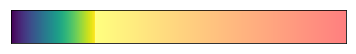

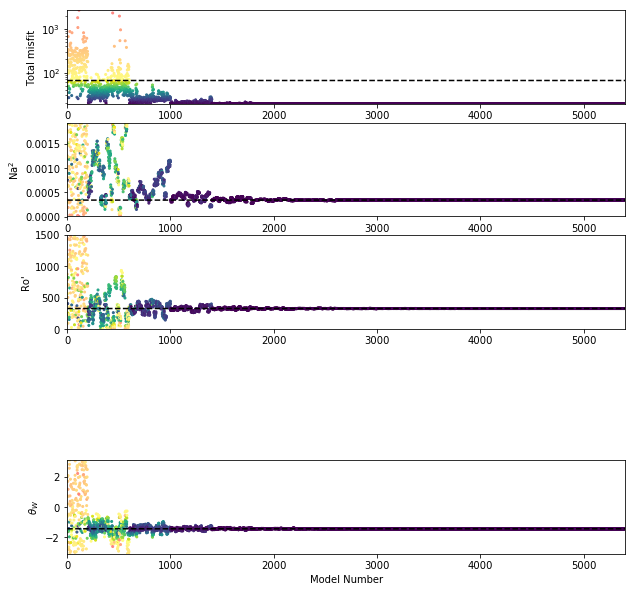

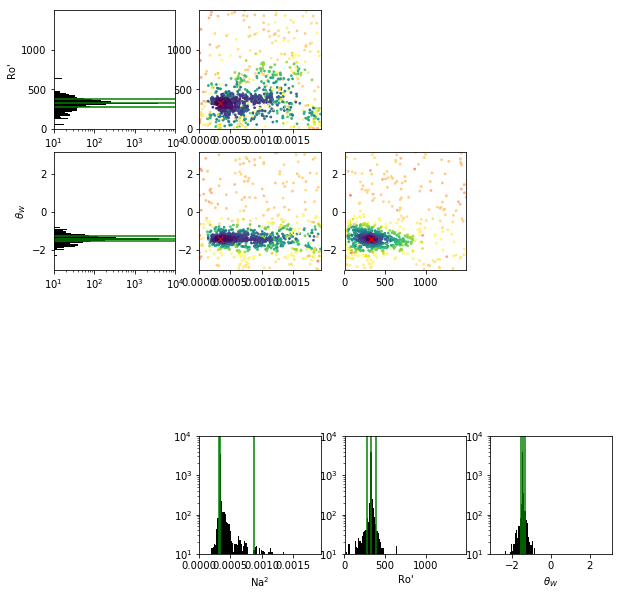

In [67]:
fig_location = '/Users/H/Documents/Tex/Reports/18-06-12/'
big_c = np.int(128*(np.log(misfit_max) - np.log([misfit_cut]))/(np.log(misfit_cut) - np.log([misfit_min])))
colors1 = plt.cm.viridis(np.linspace(0., 1, 128))
# colors1 = plt.cm.YlGnBu_r(np.linspace(0., 1, 128))
colors2 = plt.cm.autumn_r(np.linspace(0, 1, big_c))
# colors = np.vstack((colors1, colors2))
colors = np.vstack((colors1,1-(1-colors2)*0.5))
mymap = mcolors.LinearSegmentedColormap.from_list('my_colormap', colors)
plt.imshow([colors], extent=[0, 10, 0, 1])
plt.xticks([])
plt.yticks([])
plt.show()

# plot misfit
# cmin = 1e-10
# cmax = 1e2
plt.figure(figsize=[10,10])
plt.subplot(5,1,1)
cmin = misfit_min
# cmin = 1e-4
cmax = misfit_max
plt.scatter(data_NA['number'],data_NA['misfit'],c=np.log(data_NA['misfit']),s=4,cmap=mymap)
plt.plot(data_NA['number'],[misfit_cut for j in range(data_NA['number'][-1])],'--k')
plt.xlim([0,data_NA['number'][-1]])
plt.yscale('log')
plt.ylim([cmin,np.max(data_NA['misfit'])])
plt.ylim([cmin,cmax])
plt.clim(np.log([cmin,cmax]))
plt.ylabel('Total misfit')

plt.subplot(5,1,2)
plt.scatter(data_NA['number'],data_NA['Na'],c=np.log(data_NA['misfit']),s=4,cmap=mymap)
plt.plot(data_NA['number'],[data_NA['Na'][misfit_min_no] for j in range(data_NA['number'][-1])],'--k')
plt.xlim([0,data_NA['number'][-1]])
plt.ylim([np.min(data_NA['Na']),np.max(data_NA['Na'])])
plt.clim(np.log([cmin,cmax]))
plt.ylabel(r'Na$^2$')
# plt.savefig('misfit_all_100%.pdf')
plt.subplot(5,1,3)
plt.scatter(data_NA['number'],data_NA['Ro'],c=np.log(data_NA['misfit']),s=4,cmap=mymap)
plt.plot(data_NA['number'],[data_NA['Ro'][misfit_min_no] for j in range(data_NA['number'][-1])],'--k')
plt.xlim([0,data_NA['number'][-1]])
plt.ylim([np.min(data_NA['Ro']),np.max(data_NA['Ro'])])
plt.clim(np.log([cmin,cmax]))
plt.ylabel('Ro\'')
# plt.subplot(5,1,4)
# plt.scatter(data_NA['number'],data_NA['thA-O'],c=np.log(data_NA['misfit']),s=4,cmap=mymap)
# plt.plot(data_NA['number'],[data_NA['thA-O'][misfit_min_no] for j in range(data_NA['number'][-1])],'--k')
# plt.xlim([0,data_NA['number'][-1]])
# plt.ylim([np.min(data_NA['thA-O']),np.max(data_NA['thA-O'])])
# plt.clim(np.log([cmin,cmax]))
# plt.ylabel(r'$\theta_{AW}$')
plt.subplot(5,1,5)
plt.scatter(data_NA['number'],data_NA['thO'],c=np.log(data_NA['misfit']),s=4,cmap=mymap)
plt.plot(data_NA['number'],[data_NA['thO'][misfit_min_no] for j in range(data_NA['number'][-1])],'--k')
plt.xlim([0,data_NA['number'][-1]])
plt.ylim([np.min(data_NA['thO']),np.max(data_NA['thO'])])
plt.clim(np.log([cmin,cmax]))
plt.ylabel(r'$\theta_{W}$')
plt.xlabel('Model Number')
plt.show()

# plot trade off
# th1 = ThetaO
# th2 = ThetaA - ThetaO
# x - Na y - Ro
f = plt.figure(figsize=[10,10])
# cmin = np.min(data_NA['misfit'])
# cmin = 1e-4
# cmax = np.max(data_NA['misfit'])#*0.1
# cmax = 1e7
# cmin = np.min(data_NA['misfit'])
# cmin = 1e-4
# cmax = np.max(data_NA['misfit'])
# horizontal hists
plt.subplot(4,4,1)
plt.hist(data_NA['Ro'],bins=100,color='k',orientation='horizontal')
plt.axhline(inv_data_d[day_start-first_day,10],color='g')
plt.axhline(inv_data_d[day_start-first_day,11],color='g')
plt.axhline(inv_data_d[day_start-first_day,12],color='g')
plt.ylim([np.min(data_NA['Ro']),np.max(data_NA['Ro'])])
plt.xscale('log')
plt.xlim([1e1,1e4])
plt.ylabel('Ro\'')
plt.subplot(4,4,5)
plt.hist(data_NA['thO'],bins=100,color='k',orientation='horizontal')
plt.axhline(inv_data_d[day_start-first_day,13],color='g')
plt.axhline(inv_data_d[day_start-first_day,14],color='g')
plt.axhline(inv_data_d[day_start-first_day,15],color='g')
plt.ylim([np.min(data_NA['thO']),np.max(data_NA['thO'])])
plt.xscale('log')
plt.xlim([1e1,1e4])
plt.ylabel(r'$\theta_{W}$')
# plt.subplot(4,4,9)
# plt.hist(data_NA['thA-O'],bins=100,color='k',orientation='horizontal')
# plt.axhline(inv_data_d[day_start-first_day,16],color='g')
# plt.axhline(inv_data_d[day_start-first_day,17],color='g')
# plt.axhline(inv_data_d[day_start-first_day,18],color='g')
# plt.ylim([np.min(data_NA['thA-O']),np.max(data_NA['thA-O'])])
# plt.xscale('log')
# plt.xlim([1e1,1e4])
# plt.ylabel(r'$\theta_{AW}$')
# x - Na y - Ro
plt.subplot(4,4,2)
plt.scatter(data_NA['Na'],data_NA['Ro'],c=np.log(data_NA['misfit']),s=3,cmap=mymap)
plt.xlim([np.min(data_NA['Na']),np.max(data_NA['Na'])])
plt.ylim([np.min(data_NA['Ro']),np.max(data_NA['Ro'])])
plt.clim(np.log([cmin,cmax]))
# plt.ylabel('Ro')
# plt.plot([np.min(data_NA['Na']),np.max(data_NA['Na'])],[i*rossby_use for i in [1,1]],'--k')
# plt.plot([i*nansen_use for i in [1,1]],[np.min(data_NA['Ro']),np.max(data_NA['Ro'])],'--k')
plt.plot(data_NA['Na'][misfit_min_no],data_NA['Ro'][misfit_min_no],'xr')
# x - Na y - thA
plt.subplot(4,4,6)
plt.scatter(data_NA['Na'],data_NA['thO'],c=np.log(data_NA['misfit']),s=3,cmap=mymap)
plt.xlim([np.min(data_NA['Na']),np.max(data_NA['Na'])])
plt.ylim([np.min(data_NA['thO']),np.max(data_NA['thO'])])
plt.clim(np.log([cmin,cmax]))
# plt.ylabel('thO')
# plt.plot([np.min(data_NA['Na']),np.max(data_NA['Na'])],[i*th1 for i in [1,1]],'--k')
# plt.plot([i*nansen_use for i in [1,1]],[np.min(data_NA['thO']),np.max(data_NA['thO'])],'--k')
plt.plot(data_NA['Na'][misfit_min_no],data_NA['thO'][misfit_min_no],'xr')
# x - Ro y - thA
plt.subplot(4,4,7)
plt.scatter(data_NA['Ro'],data_NA['thO'],c=np.log(data_NA['misfit']),s=3,cmap=mymap)
plt.xlim([np.min(data_NA['Ro']),np.max(data_NA['Ro'])])
plt.ylim([np.min(data_NA['thO']),np.max(data_NA['thO'])])
plt.clim(np.log([cmin,cmax]))
# plt.plot([np.min(data_NA['Ro']),np.max(data_NA['Ro'])],[i*th1 for i in [1,1]],'--k')
# plt.plot([i*rossby_use for i in [1,1]],[np.min(data_NA['thO']),np.max(data_NA['thO'])],'--k')
plt.plot(data_NA['Ro'][misfit_min_no],data_NA['thO'][misfit_min_no],'xr')
# x - Na y - thO
# plt.subplot(4,4,10)
# plt.scatter(data_NA['Na'],data_NA['thA-O'],c=np.log(data_NA['misfit']),s=3,cmap=mymap)
# plt.xlim([np.min(data_NA['Na']),np.max(data_NA['Na'])])
# plt.ylim([np.min(data_NA['thA-O']),np.max(data_NA['thA-O'])])
# plt.clim(np.log([cmin,cmax]))
# # plt.ylabel('thA-O')
# # plt.plot([np.min(data_NA['Na']),np.max(data_NA['Na'])],[i*th2 for i in [1,1]],'--k')
# # plt.plot([i*nansen_use for i in [1,1]],[np.min(data_NA['thA-O']),np.max(data_NA['thA-O'])],'--k')
# plt.plot(data_NA['Na'][misfit_min_no],data_NA['thA-O'][misfit_min_no],'xr')
# x - Ro y - thO
# plt.subplot(4,4,11)
# plt.scatter(data_NA['Ro'],data_NA['thA-O'],c=np.log(data_NA['misfit']),s=3,cmap=mymap)
# plt.xlim([np.min(data_NA['Ro']),np.max(data_NA['Ro'])])
# plt.ylim([np.min(data_NA['thA-O']),np.max(data_NA['thA-O'])])
# plt.clim(np.log([cmin,cmax]))
# # plt.plot([np.min(data_NA['Ro']),np.max(data_NA['Ro'])],[i*th2 for i in [1,1]],'--k')
# # plt.plot([i*rossby_use for i in [1,1]],[np.min(data_NA['thA-O']),np.max(data_NA['thA-O'])],'--k')
# plt.plot(data_NA['Ro'][misfit_min_no],data_NA['thA-O'][misfit_min_no],'xr')
# # x - thA y - thO
# plt.subplot(4,4,12)
# plt.scatter(data_NA['thO'],data_NA['thA-O'],c=np.log(data_NA['misfit']),s=3,cmap=mymap)
# plt.xlim([np.min(data_NA['thO']),np.max(data_NA['thO'])])
# plt.ylim([np.min(data_NA['thA-O']),np.max(data_NA['thA-O'])])
# plt.clim(np.log([cmin,cmax]))
# # plt.plot([np.min(data_NA['thO']),np.max(data_NA['thO'])],[i*th2 for i in [1,1]],'--k')
# # plt.plot([i*th1 for i in [1,1]],[np.min(data_NA['thA-O']),np.max(data_NA['thA-O'])],'--k')
# plt.plot(data_NA['thO'][misfit_min_no],data_NA['thA-O'][misfit_min_no],'xr')
# bottom row histograms
plt.subplot(4,4,14)
plt.hist(data_NA['Na'],bins=100,color='k')
plt.xlim([np.min(data_NA['Na']),np.max(data_NA['Na'])])
plt.axvline(inv_data_d[day_start-first_day,7],color='g')
plt.axvline(inv_data_d[day_start-first_day,8],color='g')
plt.axvline(inv_data_d[day_start-first_day,9],color='g')
plt.yscale('log')
plt.ylim([1e1,1e4])
plt.xlabel(r'Na$^2$')
plt.subplot(4,4,15)
plt.hist(data_NA['Ro'],bins=100,color='k')
plt.axvline(inv_data_d[day_start-first_day,10],color='g')
plt.axvline(inv_data_d[day_start-first_day,11],color='g')
plt.axvline(inv_data_d[day_start-first_day,12],color='g')
plt.xlim([np.min(data_NA['Ro']),np.max(data_NA['Ro'])])
plt.yscale('log')
plt.ylim([1e1,1e4])
plt.xlabel('Ro\'')
plt.subplot(4,4,16)
plt.hist(data_NA['thO'],bins=100,color='k')
plt.xlim([np.min(data_NA['thO']),np.max(data_NA['thO'])])
plt.axvline(inv_data_d[day_start-first_day,13],color='g')
plt.axvline(inv_data_d[day_start-first_day,14],color='g')
plt.axvline(inv_data_d[day_start-first_day,15],color='g')
plt.yscale('log')
plt.ylim([1e1,1e4])
plt.xlabel(r'$\theta_{W}$')
f.savefig(fig_location+'trade_off_d5_geo_thAC.pdf',format='pdf',bbox__inches='tight')
plt.show()

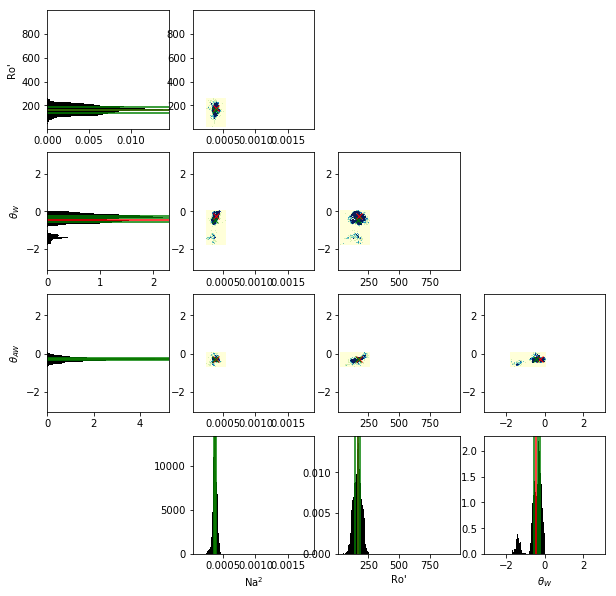

In [65]:
# bayes markov chain trade off
no_bins = 50
c_range = 5
f = plt.figure(figsize=[10,10])
# cmin = np.min(data_NA['misfit'])
# cmin = 1e-4
# cmax = np.max(data_NA['misfit'])#*0.1
# cmax = 1e7
# cmin = np.min(data_NA['misfit'])
# cmin = 1e-4
# cmax = np.max(data_NA['misfit'])
# horizontal hists
plt.subplot(4,4,1)
plt.hist(data_bayes[:,1],bins=no_bins,color='k',orientation='horizontal',normed='true')
plt.axhline(np.mean(data_bayes[:,1]),color='r')
plt.axhline(inv_data_d[day_start-first_day,31],color='g')
plt.axhline(inv_data_d[day_start-first_day,32],color='g')
plt.axhline(inv_data_d[day_start-first_day,33],color='g')
plt.ylim([np.min(data_NA['Ro']),np.max(data_NA['Ro'])])
plt.ylabel('Ro\'')
plt.subplot(4,4,5)
plt.hist(data_bayes[:,2],bins=no_bins,color='k',orientation='horizontal',normed='true')
plt.axhline(np.mean(data_bayes[:,2]),color='r')
plt.axhline(inv_data_d[day_start-first_day,34],color='g')
plt.axhline(inv_data_d[day_start-first_day,35],color='g')
plt.axhline(inv_data_d[day_start-first_day,36],color='g')
plt.ylim([np.min(data_NA['thO']),np.max(data_NA['thO'])])
plt.ylabel(r'$\theta_{W}$')
plt.subplot(4,4,9)
plt.hist(data_bayes[:,3],bins=no_bins,color='k',orientation='horizontal',normed='true')
plt.axhline(np.mean(data_bayes[:,3]),color='r')
plt.axhline(inv_data_d[day_start-first_day,37],color='g')
plt.axhline(inv_data_d[day_start-first_day,38],color='g')
plt.axhline(inv_data_d[day_start-first_day,39],color='g')
plt.ylim([np.min(data_NA['thA-O']),np.max(data_NA['thA-O'])])
plt.ylabel(r'$\theta_{AW}$')
# x - Na y - Ro
plt.subplot(4,4,2)
plt.hist2d(data_bayes[:,0],data_bayes[:,1],bins=no_bins,cmap='YlGnBu')
plt.clim([0,c_range])
plt.xlim([np.min(data_NA['Na']),np.max(data_NA['Na'])])
plt.ylim([np.min(data_NA['Ro']),np.max(data_NA['Ro'])])
plt.plot(data_NA['Na'][misfit_min_no],data_NA['Ro'][misfit_min_no],'xr')
plt.plot(nansen2_b,rossby_b,'xg')
# x - Na y - thA
plt.subplot(4,4,6)
plt.hist2d(data_bayes[:,0],data_bayes[:,2],bins=no_bins,cmap='YlGnBu')
plt.clim([0,c_range])
plt.xlim([np.min(data_NA['Na']),np.max(data_NA['Na'])])
plt.ylim([np.min(data_NA['thO']),np.max(data_NA['thO'])])
plt.plot(data_NA['Na'][misfit_min_no],data_NA['thO'][misfit_min_no],'xr')
plt.plot(nansen2_b,thO_b,'xg')
# x - Ro y - thA
plt.subplot(4,4,7)
plt.hist2d(data_bayes[:,1],data_bayes[:,2],bins=no_bins,cmap='YlGnBu')
plt.clim([0,c_range])
plt.xlim([np.min(data_NA['Ro']),np.max(data_NA['Ro'])])
plt.ylim([np.min(data_NA['thO']),np.max(data_NA['thO'])])
plt.plot(data_NA['Ro'][misfit_min_no],data_NA['thO'][misfit_min_no],'xr')
plt.plot(rossby_b,thO_b,'xg')
# x - Na y - thO
plt.subplot(4,4,10)
plt.hist2d(data_bayes[:,0],data_bayes[:,3],bins=no_bins,cmap='YlGnBu')
plt.clim([0,c_range])
plt.xlim([np.min(data_NA['Na']),np.max(data_NA['Na'])])
plt.ylim([np.min(data_NA['thA-O']),np.max(data_NA['thA-O'])])
plt.plot(data_NA['Na'][misfit_min_no],data_NA['thA-O'][misfit_min_no],'xr')
plt.plot(nansen2_b,thA_O_b,'xg')
# x - Ro y - thO
plt.subplot(4,4,11)
plt.hist2d(data_bayes[:,1],data_bayes[:,3],bins=no_bins,cmap='YlGnBu')
plt.clim([0,c_range])
plt.xlim([np.min(data_NA['Ro']),np.max(data_NA['Ro'])])
plt.ylim([np.min(data_NA['thA-O']),np.max(data_NA['thA-O'])])
plt.plot(data_NA['Ro'][misfit_min_no],data_NA['thA-O'][misfit_min_no],'xr')
plt.plot(rossby_b,thA_O_b,'xg')
# x - thA y - thO
plt.subplot(4,4,12)
plt.hist2d(data_bayes[:,2],data_bayes[:,3],bins=no_bins,cmap='YlGnBu')
plt.clim([0,c_range])
plt.xlim([np.min(data_NA['thO']),np.max(data_NA['thO'])])
plt.ylim([np.min(data_NA['thA-O']),np.max(data_NA['thA-O'])])
plt.plot(data_NA['thO'][misfit_min_no],data_NA['thA-O'][misfit_min_no],'xr')
plt.plot(thO_b,thA_O_b,'xg')
# bottom row histograms
plt.subplot(4,4,14)
plt.hist(data_bayes[:,0],bins=no_bins,color='k',normed='true')
plt.axvline(np.mean(data_bayes[:,0]),color='r')
plt.axvline(inv_data_d[day_start-first_day,28],color='g')
plt.axvline(inv_data_d[day_start-first_day,29],color='g')
plt.axvline(inv_data_d[day_start-first_day,30],color='g')
plt.xlim([np.min(data_NA['Na']),np.max(data_NA['Na'])])
plt.xlabel(r'Na$^2$')
plt.subplot(4,4,15)
plt.hist(data_bayes[:,1],bins=no_bins,color='k',normed='true')
plt.axvline(np.mean(data_bayes[:,1]),color='r')
plt.axvline(inv_data_d[day_start-first_day,31],color='g')
plt.axvline(inv_data_d[day_start-first_day,32],color='g')
plt.axvline(inv_data_d[day_start-first_day,33],color='g')
plt.xlim([np.min(data_NA['Ro']),np.max(data_NA['Ro'])])
plt.xlabel('Ro\'')
ax =plt.subplot(4,4,16)
plt.hist(data_bayes[:,2],bins=no_bins,color='k',normed='true')
plt.axvline(np.mean(data_bayes[:,2]),color='r')
plt.axvline(inv_data_d[day_start-first_day,34],color='g')
plt.axvline(inv_data_d[day_start-first_day,35],color='g')
plt.axvline(inv_data_d[day_start-first_day,36],color='g')
plt.xlim([np.min(data_NA['thO']),np.max(data_NA['thO'])])
plt.xlabel(r'$\theta_{W}$')


# f.savefig(fig_location+'trade_off3.pdf',format='pdf',bbox__inches='tight')
plt.show()

In [ ]:
plt.figure(figsize=[10,10])
cmin = misfit_min
# cmin = 1e-4
cmax = misfit_max
plt.scatter(data_NA['number'],data_NA['misfit'],c=np.log(data_NA['misfit']),s=4,cmap=mymap)
plt.plot(data_NA['number'],[misfit_cut for j in range(data_NA['number'][-1])],'--k')
plt.xlim([0,data_NA['number'][-1]])
plt.yscale('log')
plt.ylim([cmin,np.max(data_NA['misfit'])])
plt.clim(np.log([cmin,cmax]))
plt.ylabel('Total misfit')
plt.show()

In [ ]:

big_c = np.int(128*(np.log(misfit_max) - np.log([misfit_cut]))/(np.log(misfit_cut) - np.log([misfit_min])))
colors1 = plt.cm.viridis(np.linspace(0., 1, 128))
# colors1 = plt.cm.YlGnBu_r(np.linspace(0., 1, 128))
colors2 = plt.cm.autumn_r(np.linspace(0, 1, big_c))
colors = np.vstack((colors1,1-(1-colors2)*0.3))
mymap = mcolors.LinearSegmentedColormap.from_list('my_colormap', colors)
plt.imshow([colors], extent=[0, 10, 0, 1])
plt.xticks([])
plt.yticks([])
plt.show()


In [45]:
nansen_calc = st.median(data_NA_cut[1,0:i_cut])
rossby_calc = st.median(data_NA_cut[2,0:i_cut])
thO_calc    = st.median(data_NA_cut[3,0:i_cut])
thA_O_calc  = st.median(data_NA_cut[4,0:i_cut])
print('Nansen calculated',(data_NA['Na'][misfit_min_no]),nansen_calc)
print('Nansen calculated',np.sqrt(data_NA['Na'][misfit_min_no]),np.sqrt(nansen_calc))
print('Rossby calculated',data_NA['Ro'][misfit_min_no],rossby_calc)
print('ThetaA calculated',
      np.rad2deg(data_NA['thA-O'][misfit_min_no]+data_NA['thO'][misfit_min_no]),np.rad2deg(thA_O_calc + thO_calc))
print('ThetaO calculated',np.rad2deg(data_NA['thO'][misfit_min_no]),np.rad2deg(thO_calc))
print('ThetaAO calculated',np.rad2deg(data_NA['thA-O'][misfit_min_no]),np.rad2deg(thA_O_calc))
print('Ca calculated',(data_NA['Na'][misfit_min_no]/data_NA['Ro'][misfit_min_no])*(rhoi/rhoa))
print('Co calculated',(rhoi/rhoo)/data_NA['Ro'][misfit_min_no])
print('Ca calculated',(nansen_calc/rossby_calc*(rhoi/rhoa)))
print('Co calculated',(rhoi/rhoo)/rossby_calc)

Nansen calculated 0.000384245679 0.000376199838
Nansen calculated 0.0196021855669 0.0193958716741
Rossby calculated 174.817993 167.833206
ThetaA calculated -28.9616140005 -35.3089019906
ThetaO calculated -13.424320181 -19.1046879905
ThetaAO calculated -15.5372938195 -16.2042140001
Ca calculated 0.00161243488314
Co calculated 0.00511252971103
Ca calculated 0.00164437186022
Co calculated 0.00532530006747


In [ ]:
# # disassemble vectors
# # forcing_1
# vec_strd = 5
# all_vecs = np.empty([np.int((data_NA['number'][-1]-it1)/vec_strd+1),nbals,5],float)
# jj = 0
# for j in range(it1,data_NA['number'][-1],vec_strd):
# # for j in range(misfit_min_no,misfit_min_no+1):
#     for i in range(nbals):
#         all_vecs[jj,i,0],all_vecs[jj,i,1] = freedrift.wnd_i_o_mag(
#                           data_mean_big[day_start+i,0,d_w],data_mean_big[day_start+i,1,d_w],
#                           data_NA['Na'][j],data_NA['Ro'][j]*-data_in[1+11*nbals+i],
#                           data_NA['thA-O'][j]+data_NA['thO'][j],data_NA['thO'][j])
#         all_vecs[jj,i,2],all_vecs[jj,i,3] = freedrift.i_o_mag(
#                           data_mean_single[day_start+i,2],data_mean_single[day_start+i,3],
#                           data_NA['Na'][j],data_NA['Ro'][j]*-data_in[1+11*nbals+i],
#                           data_NA['thA-O'][j]+data_NA['thO'][j],data_NA['thO'][j])
#         all_vecs[jj,i,4] = data_NA['misfit'][j]
#     jj += 1
# #     print(jj,j)
# j = misfit_min_no
# for i in range(nbals):
#     all_vecs[jj,i,0],all_vecs[jj,i,1] = freedrift.wnd_i_o_mag(
#                           data_mean_big[day_start+i,0,d_w],data_mean_big[day_start+i,1,d_w],
#                           data_NA['Na'][j],data_NA['Ro'][j]*data_in[1+11*nbals+i],
#                           data_NA['thA-O'][j]+data_NA['thO'][j],data_NA['thO'][j])
#     all_vecs[jj,i,2],all_vecs[jj,i,3] = freedrift.i_o_mag(
#                           data_mean_single[day_start+i,2],data_mean_single[day_start+i,3],
#                           data_NA['Na'][j],data_NA['Ro'][j]*data_in[1+11*nbals+i],
#                           data_NA['thA-O'][j]+data_NA['thO'][j],data_NA['thO'][j])
#     all_vecs[jj,i,4] = data_NA['misfit'][j]
        

In [ ]:
bal_p

In [ ]:
# disassemble vectors
# just the cut list
# forcing_1
vec_strd = 5
all_vecs = np.empty([int(i_cut/vec_strd+1)+1,nbals,5],float)
jj = 0
for j in range(0,i_cut,vec_strd):
# for j in range(misfit_min_no,misfit_min_no+1):
    for i in range(nbals):
        ii = bal_p[i]
        all_vecs[jj,i,0],all_vecs[jj,i,1] = freedrift.wnd_i_o_mag(
                          -data_mean_big[day_start+ii,0,d_w],-data_mean_big[day_start+ii,1,d_w],
                          data_NA_cut[1,j],data_NA_cut[2,j]*data_in[1+11*nbals+ii],
                          data_NA_cut[4,j]+data_NA_cut[3,j],data_NA_cut[3,j])
        all_vecs[jj,i,2],all_vecs[jj,i,3] = freedrift.i_o_mag(
                          data_mean_single[day_start+ii,2],data_mean_single[day_start+ii,3],
                          data_NA_cut[1,j],data_NA_cut[2,j]*data_in[1+11*nbals+ii],
                          data_NA_cut[4,j]+data_NA_cut[3,j],data_NA_cut[3,j])
        all_vecs[jj,i,4] = data_NA_cut[5,j]
    jj += 1
#     print(jj,j)
j = misfit_min_no
for i in range(nbals):
    ii = bal_p[i]
    all_vecs[jj,i,0],all_vecs[jj,i,1] = freedrift.wnd_i_o_mag(
                          -data_mean_big[day_start+ii,0,d_w],-data_mean_big[day_start+ii,1,d_w],
                          data_NA['Na'][j],data_NA['Ro'][j]*data_in[1+11*nbals+ii],
                          data_NA['thA-O'][j]+data_NA['thO'][j],data_NA['thO'][j])
    all_vecs[jj,i,2],all_vecs[jj,i,3] = freedrift.i_o_mag(
                          data_mean_single[day_start+ii,2],data_mean_single[day_start+ii,3],
                          data_NA['Na'][j],data_NA['Ro'][j]*data_in[1+11*nbals+ii],
                          data_NA['thA-O'][j]+data_NA['thO'][j],data_NA['thO'][j])
    all_vecs[jj,i,4] = data_NA['misfit'][j]
    vec_plot = jj
        

In [ ]:
# want arrows for the obs and best, scatter all the rest with mymap
wnd_range = np.max(data_mean_single[day_start:day_start+nbals,4])
wnd_range = 0.99*np.max(np.maximum(all_vecs[-1,:,0:2],wnd_range))
wnd_scale = 0.03
weight = 0.006
# wnd_range = np.max(wind_mag)
# wnd_range = 0.99*np.max(np.maximum(all_vecs[-1,:,0:2],wnd_range))
# wnd_scale = 0.04
plt.figure(figsize=[10,10*nbals])
plt.rc('text', usetex=True)
for nb in range(nbals):
# for nb in range(nbals):
    ax = plt.subplot(nbals,1,nb+1)
#     #   calculated vectors
    # wind
    plt.scatter(wnd_scale*all_vecs[0:vec_plot,nb,0],wnd_scale*all_vecs[0:vec_plot,nb,1],
                c=np.log(all_vecs[0:vec_plot,nb,4]),s=3,cmap=mymap)
    plt.scatter(-all_vecs[0:vec_plot,nb,2],-all_vecs[0:vec_plot,nb,3],
                c=np.log(all_vecs[0:vec_plot,nb,4]),s=3,cmap=mymap)
    plt.clim(np.log([cmin,cmax]))
    # best vectors
    plt.arrow(0.0,0.0,wnd_scale*all_vecs[vec_plot,nb,0],wnd_scale*all_vecs[vec_plot,nb,1],
               length_includes_head = 'true',linestyle='dashed',color='k',alpha = 0.7)
    plt.arrow(0.0,0.0,-all_vecs[vec_plot,nb,2],-all_vecs[vec_plot,nb,3],
               length_includes_head = 'true',linestyle='dashed',color='b',alpha = 0.7)
# #     #   original vectors
#     plt.arrow(0,0,wnd_scale*data_mean_single[day_start+nb,2],wnd_scale*data_mean_single[day_start+nb,3],
#               color='k',length_includes_head = 'true',width=weight)
#     plt.arrow(0,0,data_mean_big[day_start+nb,0,d_w],data_mean_big[day_start+nb,1,d_w],
#               color='b',length_includes_head = 'true',width=weight)
    plt.xlim([-wnd_range*wnd_scale,wnd_range*wnd_scale])
    plt.ylim([-wnd_range*wnd_scale,wnd_range*wnd_scale])
    j = bal_p[nb]
    jj = day_start + j
    plt.arrow(0,0,wnd_scale*data_mean_single[jj,2],wnd_scale*data_mean_single[jj,3],
              color='k',length_includes_head = 'true',width=weight)
    plt.arrow(0,0,data_mean_big[jj,0,d_w],data_mean_big[jj,1,d_w],
              color='b',length_includes_head = 'true',width=weight)
    for i in range(data_ranges[jj,0],data_ranges[jj,1]):
        plt.arrow(0,0,u[d_w,i],v[d_w,i],alpha=0.2,color='b')
    for i in range(data_ranges[jj,2],data_ranges[jj,3]):
        val[2] =  np.sin(np.deg2rad(aws_02_data[i][12]))*aws_02_data[i][11]
        val[3] =  np.cos(np.deg2rad(aws_02_data[i][12]))*aws_02_data[i][11]
        plt.arrow(0,0,wnd_scale*val[2],wnd_scale*val[3],alpha=0.2,color='k')
# #     plt.arrow(-wnd_scale/2,-wind_mag[nb]*wnd_scale/2,wnd_scale,0,
# #               color='k',length_includes_head = 'true',width=0.0015)
# #     plt.arrow(-wnd_scale/2,-3*wind_mag[nb]*wnd_scale/4,wnd_scale,0,
# # #               color='b',length_includes_head = 'true',width=0.0015)
# #     plt.arrow(-wnd_scale/2,-wnd_range*wnd_scale/2,wnd_scale,0,
# #               color='k',length_includes_head = 'true',width=0.0015)
# #     plt.arrow(-wnd_scale/2,-3*wnd_range*wnd_scale/4,wnd_scale,0,
# #               color='b',length_includes_head = 'true',width=0.0015)
# #     plt.text(wnd_scale,-wind_mag[nb]*wnd_scale/2,r'Wind $ = 1 $ m s$^{-1}$',fontsize=20,horizontalalignment='left')
# #     plt.text(wnd_scale,-3*wind_mag[nb]*wnd_scale/4,r'$\bf{U}_{WI}  = 2 $ cm s$^{-1}$',fontsize=20,horizontalalignment='left')
#     plt.text(wnd_scale,-wnd_range*wnd_scale/2,r'Wind $ = 1 $ m s$^{-1}$',fontsize=20,horizontalalignment='left')
#     plt.text(wnd_scale,-3*wnd_range*wnd_scale/4,r'$\bf{U}_{WI}  = 2 $ cm s$^{-1}$',fontsize=20,horizontalalignment='left')
    ax.axis('off')
plt.show()

In [ ]:
nb

In [ ]:
# disassemble forces
# forcing_1
all_forces = np.empty([data_NA['number'][-1],nbals,6])
# for j in tqdm(data_NA['number']-1):
# for j in range(data_NA['number'][-1]-10,data_NA['number'][-1]-1):
# for j in tqdm(data_NA['number']-1):
for j in range(misfit_min_no,misfit_min_no+1):
    for i in range(0,5):
        all_forces[j,i,:] = freedrift.force_bal(
                          data_mean_single[day_start+nb,2],data_mean_single[day_start+nb,3],
                          data_mean_big[day_start+nb,0,d_w],data_mean_big[day_start+nb,1,d_w],
                          data_NA['Na'][j]/data_NA['Ro'][j]*rhoi,rhoi/data_NA['Ro'][j],rhoi*data_in[1+11*nbals+i],
                          data_NA['thA-O'][j]+data_NA['thO'][j],data_NA['thO'][j])
force_magw = np.empty([nbals])
for i in range(nbals):
    force_magw[i] = np.max(np.hypot(all_forces[misfit_min_no,i,0],all_forces[misfit_min_no,i,1]))

In [ ]:
# disassemble misfits
vec_strd = 10
all_misfits = np.empty([np.int((data_NA['number'][-1]-it1)/vec_strd),nbals,4])
# for j in tqdm(data_NA['number']-1):
jj = 0
for j in range(it1,data_NA['number'][-1],vec_strd):
    for ii in range(nbals):
        i = bal_p[ii]
        all_misfits[jj,i,0] = freedrift.misfit_a_io(
                          data_mean_single[day_start+i,2],data_mean_single[day_start+i,3],
                          -data_mean_big[day_start+i,0,d_w],-data_mean_big[day_start+i,1,d_w],
                          data_NA['Na'][j],data_NA['Ro'][j]*data_in[1+11*nbals+i],
                          data_NA['thA-O'][j]+data_NA['thO'][j],data_NA['thO'][j]
                )*beta_a[i]/data_in[1+3*nbals+i]**2
        all_misfits[jj,i,1] = freedrift.misfit_i_o(
                          data_mean_single[day_start+i,2],data_mean_single[day_start+i,3],
                          -data_mean_big[day_start+i,0,d_w],-data_mean_big[day_start+i,1,d_w],
                          data_NA['Na'][j],data_NA['Ro'][j]*data_in[1+11*nbals+i],
                          data_NA['thA-O'][j]+data_NA['thO'][j],data_NA['thO'][j]
                )*beta_i[i]/data_in[1+7*nbals+i]**2
        fb_ratio = np.mean([data_in[1+3*nbals+i]/data_in[1+2*nbals+i],
                     data_in[1+7*nbals+i]/data_in[1+6*nbals+i]]) 
        all_misfits[jj,i,2] = freedrift.misfit_fb2(
                          data_mean_single[day_start+i,2],data_mean_single[day_start+i,3],
                          -data_mean_big[day_start+i,0,d_w],-data_mean_big[day_start+i,1,d_w],
                          data_NA['Na'][j]*data_NA['Ro'][j]/rhoi,
                          rhoi/data_NA['Ro'][j],rhoi*data_in[1+11*nbals+i],
                          data_NA['thA-O'][j]+data_NA['thO'][j],data_NA['thO'][j]
                )*beta_fb[i]/fb_ratio**2
        all_misfits[jj,i,3] = data_NA['misfit'][j]
    jj += 1

In [ ]:
plt.figure(figsize=[30,10])
# cmin = 1e-10
cmin = misfit_min*1e-9
# cmin = 1e-4
cmax = misfit_max*1e3
# cmin = 1e-12
for i in range(nbals):
    plt.subplot(1,nbals,i+1)
# for i in range(0,3):
#     plt.subplot(1,3,i+1)
    plt.plot(all_misfits[:,i,0],alpha = 1.0,c='k')
    plt.plot(np.sum(all_misfits[:,i,0:3],axis=1),c='k',alpha=0.5)
    plt.plot(all_misfits[:,i,1],alpha = 1.0,c='r')
    plt.plot(all_misfits[:,i,2],alpha = 1.0,c='b')
    plt.plot(all_misfits[:,i,3],'xg')
    plt.yscale('log')
    plt.ylim([cmin,cmax])
plt.show()

plt.plot(np.sum(all_misfits[:,:,0],axis=1),c='k')
plt.plot(np.sum(all_misfits[:,:,1],axis=1),c='r')
plt.plot(np.sum(all_misfits[:,:,2],axis=1),c='b')
plt.plot(all_misfits[:,0,3],'xg')
plt.plot(np.sum(np.sum(all_misfits[:,:,0:3],axis=2),axis=1),c='k',alpha=0.5)
plt.ylim([cmin,cmax])
plt.yscale('log')
# plt.savefig('misfit_sep_100%.pdf')
plt.show()